# Table of contents

* [1. Datasets import](#import)
* [2. Data Exploration](#exploration)
  * [2.1 Numerical Features](#num)
  * [2.2 Categorical Features](#cat)
* [3. Preprocessing steps](#preprocessing)
  * [3.1. Incoherences](#incoherences)
  * [3.2. Outliers](#outliers)
  * [3.3. Missing Values](#miss)
  * [3.4. Feature Engineering](#feature_eng)
  * [3.5. Encoding and Grouping](#enc)
  * [3.6. Scaling](#scaling)
  * [3.7. Split and UnderSmapler](#us)
  * [3.8. Feature selection](#fselection)
    * [3.8.1. Filter methods](#filter)
        * [3.8.1.1 Univariate variables](#univariate)
        * [3.8.1.2. Chi-squared for categorical variables](#chi2)
        * [3.8.1.3. Mutual information](#mutual_info)
        * [3.8.1.4. Spearman Correlation](#spearman)
    * [3.8.2. Wrapper methods - RFE](#rfe)
    * [3.8.3. Embedded methods - Lasso](#lasso)
    * [3.8.4. Embedded methods - DecisionTree](#dt)
* [4. Model Selection and Evaluation](#model_selection)
* [5. Models Fine Tuning](#finetuning)
  * [6.1. Logistic Regression](#lr)
  * [6.2. Gradient Boosting](#gb)
  * [6.3. Random Forest](#rf)
  * [6.4. SVC](#svc)
* [7. Predictions for the test data](#testpredictions)

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basics
import pandas as pd
import numpy as np
import ast
from scipy.stats import uniform, randint, chi2_contingency
from collections import Counter
import itertools

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Preporcessing
from sklearn.preprocessing import MinMaxScaler

# Model split and sampler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Feature Selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation and parameter search
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.model_selection import cross_validate,cross_val_score, cross_val_predict, KFold, RepeatedKFold,GridSearchCV,RandomizedSearchCV

# Datasets import <a class="anchor" id="import"></a>

In [2]:
df_train = pd.read_csv('train.csv',
                 sep=',',
               index_col = ['encounter_id'],
                 na_values=['?']
                )

In [3]:
df_test = pd.read_csv('test.csv',
                 sep=',',
                 index_col = ['encounter_id'],
                 na_values=['?']
                )

# Data Exploration <a class="anchor" id="exploration"></a>

In [4]:
train = df_train.copy()
test = df_test.copy()

In [5]:
df_train.columns

Index(['country', 'patient_id', 'race', 'gender', 'age', 'weight',
       'payer_code', 'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass'],
      dtype='object')

In [6]:
train.shape

(71236, 30)

In [7]:
test.shape

(30530, 28)

In [8]:
train.head(50).T

encounter_id,533253,426224,634063,890610,654194,269878,182051,964239,418598,760130,...,488420,315879,101519,224701,471683,469306,201542,806395,942220,810223
country,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA,...,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA
patient_id,70110,29775006,80729253,2919042,84871971,279288,1566405,60052095,85756257,96104214,...,40852710,1385559,73247976,84376332,86280993,89413974,98584524,3360294,98754759,2486844
race,Caucasian,AfricanAmerican,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Other,Caucasian,Caucasian,...,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Other,AfricanAmerican,Caucasian,AfricanAmerican
gender,Female,Male,Female,Male,Female,Female,Female,Male,Female,Female,...,Male,Male,Female,Male,Male,Female,Male,Female,Female,Female
age,[70-80),[50-60),[60-70),[60-70),[70-80),[50-60),[50-60),[70-80),[50-60),[70-80),...,[70-80),[60-70),[40-50),[70-80),[70-80),[60-70),[50-60),[30-40),[30-40),[30-40)
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payer_code,NaN,NaN,NaN,MC,HM,NaN,UN,MC,MC,MC,...,MC,NaN,MD,MC,MC,SP,SP,NaN,UN,NaN
outpatient_visits_in_previous_year,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,1,0,0,0,0
emergency_visits_in_previous_year,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
inpatient_visits_in_previous_year,2,0,1,1,0,0,0,0,0,0,...,4,0,5,1,3,0,3,0,3,7


In [9]:
test.head(50)

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication
encounter_id,,,,,,,,,,,,,,,,,,,,,
499502,USA,103232799,Caucasian,Male,[80-90),NaN,HM,0,0,0,...,14,491,414,250,6,NaN,NaN,No,Yes,['metformin']
447319,USA,93395304,Caucasian,Male,[20-30),NaN,HM,0,0,1,...,7,250.13,70,794,7,>300,NaN,No,No,[]
309126,USA,6281586,AfricanAmerican,Male,[30-40),NaN,NaN,0,0,0,...,12,786,250.6,536,6,NaN,NaN,No,Yes,['insulin']
181183,USA,67381308,Caucasian,Male,[50-60),NaN,BC,0,0,0,...,16,820,873,E884,9,NaN,NaN,Ch,Yes,"['metformin', 'glyburide', 'insulin']"
359339,USA,71670204,Caucasian,Male,[60-70),NaN,NaN,0,0,0,...,10,599,427,414,9,NaN,NaN,No,Yes,['metformin']
319065,USA,53751546,AfricanAmerican,Female,[30-40),NaN,NaN,0,0,0,...,8,780,403,V45,8,NaN,NaN,No,No,[]
403099,USA,104092839,AfricanAmerican,Male,[50-60),NaN,HM,0,0,0,...,18,577,305,276,9,NaN,>8,Ch,Yes,['insulin']
834256,USA,6219702,Caucasian,Female,NaN,NaN,NaN,0,0,0,...,21,611,683,296,5,NaN,>8,Ch,Yes,"['glipizide', 'insulin']"
804322,USA,25918992,Caucasian,Female,[50-60),NaN,NaN,0,0,0,...,20,197,415,558,8,NaN,>7,No,Yes,['metformin']


In [10]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                      5070
gender                                       0
age                                       3557
weight                                   68990
payer_code                               28201
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                        34922
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           16
secondary_diagnosis                        262
additional_di

In [11]:
test.isna().sum()

country                                      0
patient_id                                   0
race                                      2191
gender                                       0
age                                       1531
weight                                   29579
payer_code                               12055
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            1585
medical_specialty                        15027
average_pulse_bpm                            0
discharge_disposition                     1101
admission_source                          2063
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            5
secondary_diagnosis                         96
additional_di

## Numerical Features <a class="anchor" id="num"></a>

In [12]:
df = train

#### outpatient_visits_in_previous_year

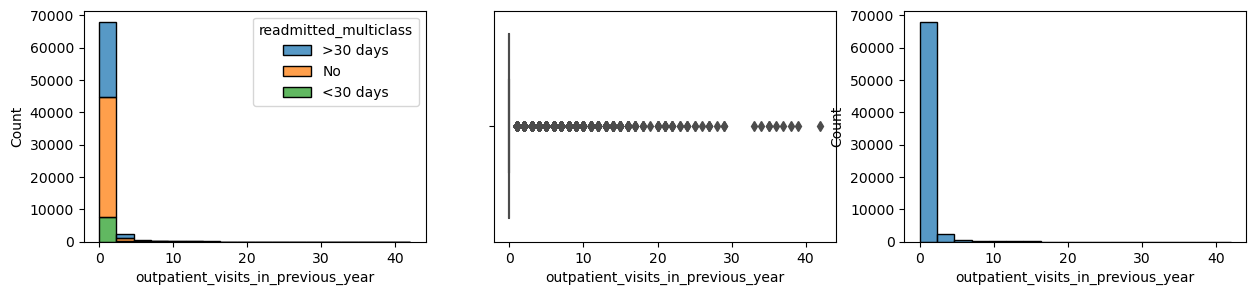

In [13]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = train, x = 'outpatient_visits_in_previous_year', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = train, x = 'outpatient_visits_in_previous_year', ax=ax[2])
sns.boxplot(data = train, x = 'outpatient_visits_in_previous_year', color = 'b', ax=ax[1])
fig.show()

<Axes: xlabel='outpatient_visits_in_previous_year', ylabel='Count'>

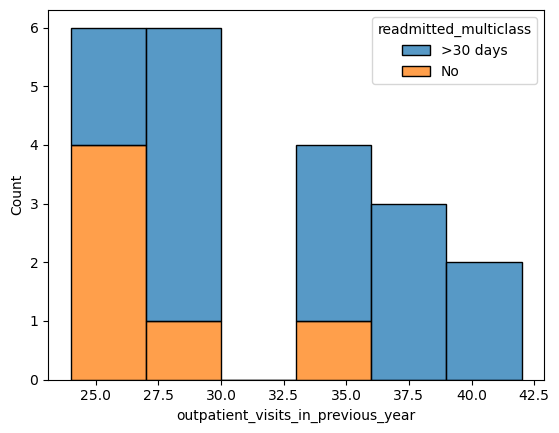

In [14]:
sns.histplot(data = df[df['outpatient_visits_in_previous_year']>=24], x = 'outpatient_visits_in_previous_year', hue = 'readmitted_multiclass', multiple= 'stack')

In [15]:
len(df[df['outpatient_visits_in_previous_year'] > 0])/len(df)

0.163526868437307

#### emergency_visits_in_previous_year

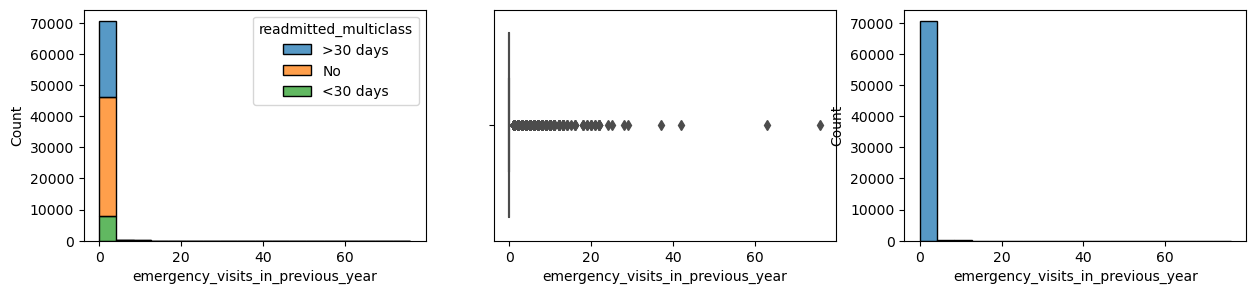

In [16]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'emergency_visits_in_previous_year', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'emergency_visits_in_previous_year', ax=ax[2])
sns.boxplot(data = df, x = 'emergency_visits_in_previous_year', color = 'b', ax=ax[1])
fig.show()

<Axes: xlabel='emergency_visits_in_previous_year', ylabel='Count'>

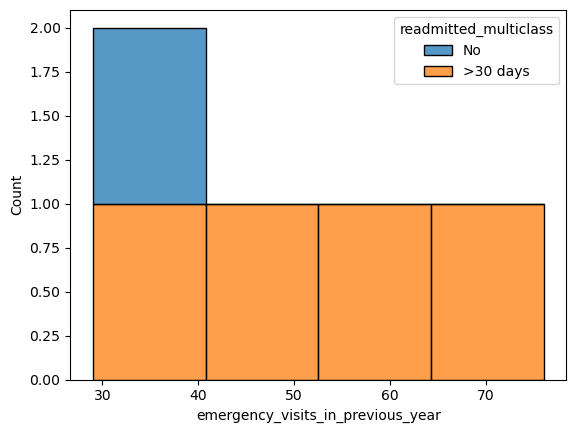

In [17]:
sns.histplot(data = df[df['emergency_visits_in_previous_year']>=29], x = 'emergency_visits_in_previous_year', hue = 'readmitted_multiclass', multiple= 'stack')

In [18]:
len(df[df['emergency_visits_in_previous_year'] > 0])/len(df)

0.11221854118704026

#### inpatient_visits_in_previous_year

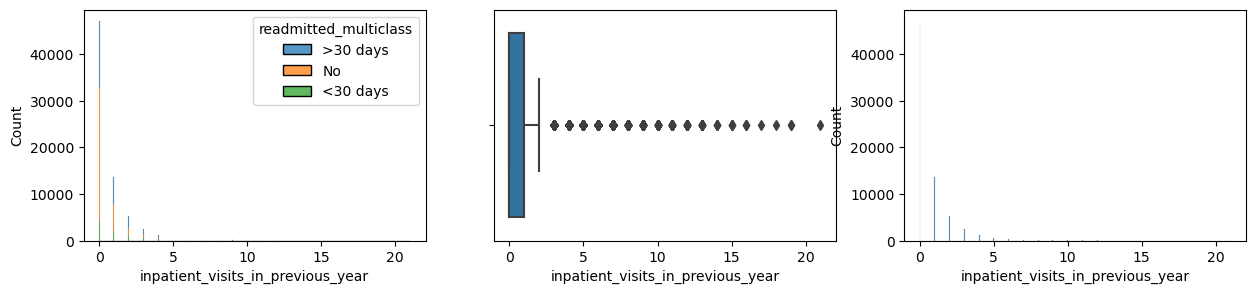

In [19]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'inpatient_visits_in_previous_year', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'inpatient_visits_in_previous_year', ax=ax[2])
sns.boxplot(data = df, x = 'inpatient_visits_in_previous_year', ax=ax[1])
fig.show()

<Axes: xlabel='inpatient_visits_in_previous_year', ylabel='Count'>

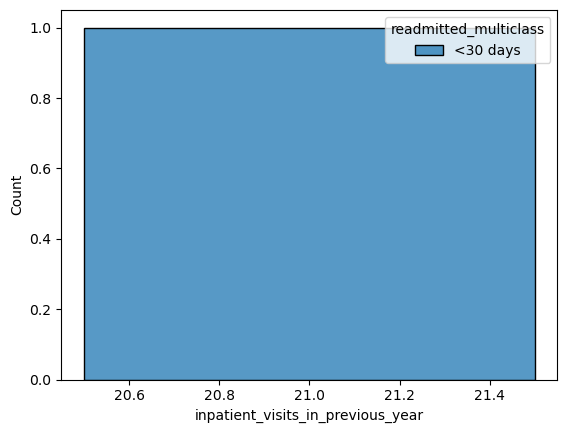

In [20]:
sns.histplot(data = df[df['inpatient_visits_in_previous_year']>=21], x = 'inpatient_visits_in_previous_year', hue = 'readmitted_multiclass', multiple= 'stack')

In [21]:
len(df[df['inpatient_visits_in_previous_year'] > 0])/len(df)

0.3369784940198776

#### average_pulse_bpm

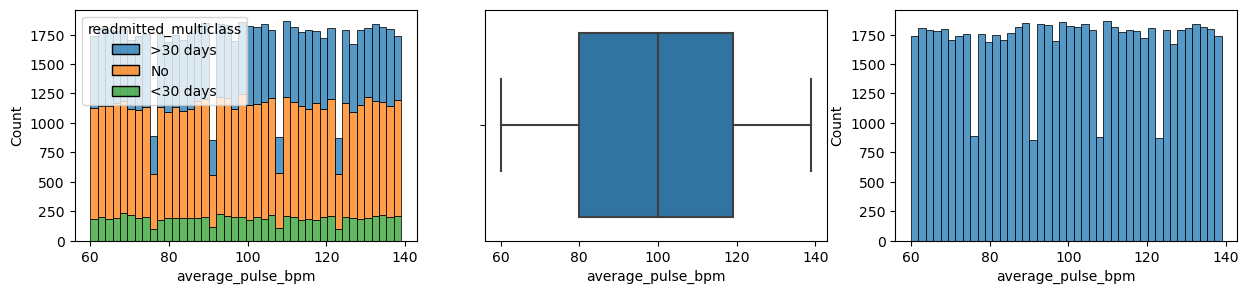

In [22]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'average_pulse_bpm', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'average_pulse_bpm', ax=ax[2])
sns.boxplot(data = df, x = 'average_pulse_bpm', ax=ax[1])
fig.show()

#### length_of_stay_in_hospital               

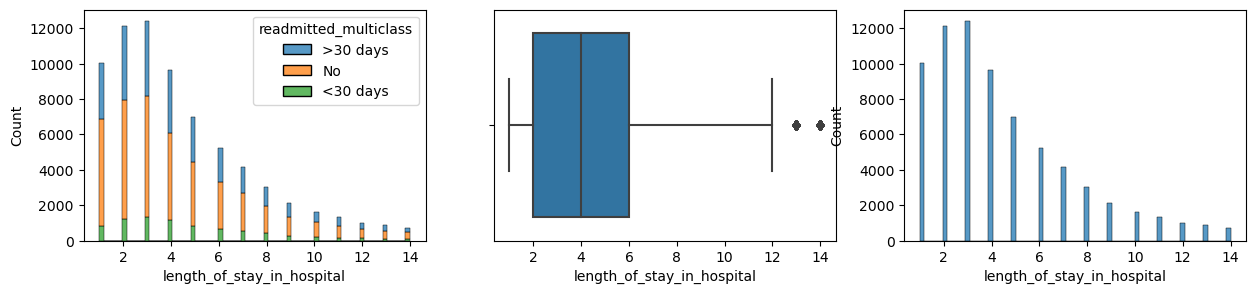

In [23]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'length_of_stay_in_hospital', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'length_of_stay_in_hospital', ax=ax[2])
sns.boxplot(data = df, x = 'length_of_stay_in_hospital', ax=ax[1])
fig.show()

#### number_lab_tests

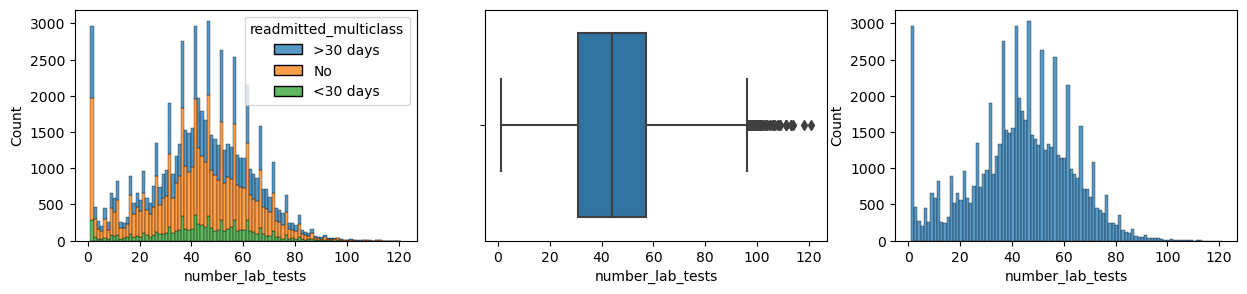

In [24]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'number_lab_tests', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'number_lab_tests', ax=ax[2])
sns.boxplot(data = df, x = 'number_lab_tests', ax=ax[1])
fig.show()

#### non_lab_procedures

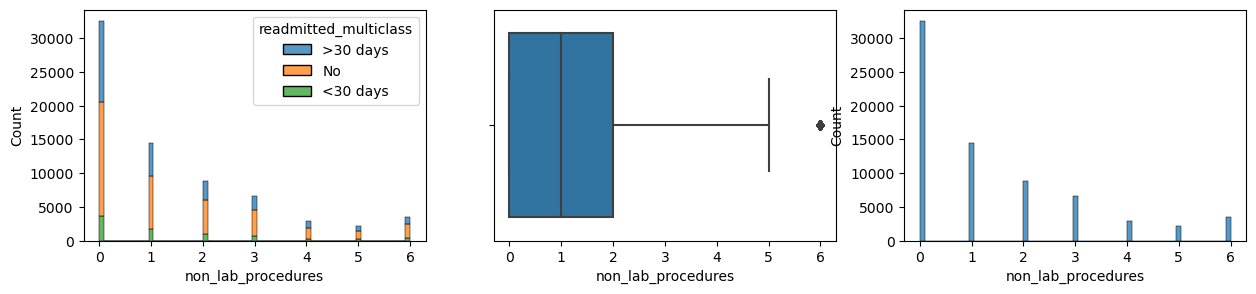

In [25]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'non_lab_procedures', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'non_lab_procedures', ax=ax[2])
sns.boxplot(data = df, x = 'non_lab_procedures',  ax=ax[1])
fig.show()

#### number_of_medications

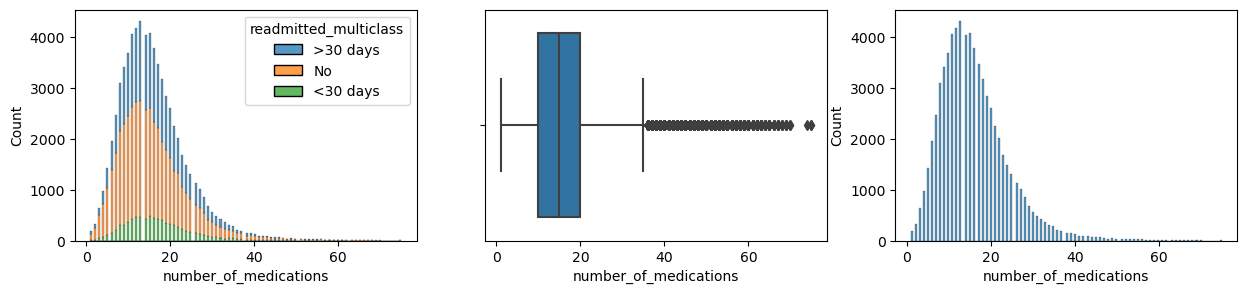

In [26]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'number_of_medications', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'number_of_medications', ax=ax[2])
sns.boxplot(data = df, x = 'number_of_medications', ax=ax[1])
fig.show()

<Axes: xlabel='number_of_medications', ylabel='Count'>

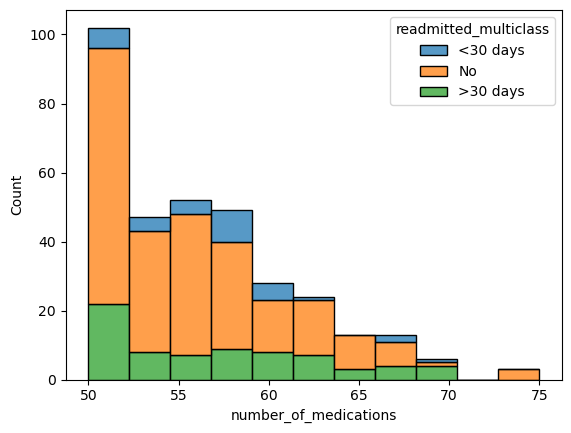

In [27]:
sns.histplot(data = df[df['number_of_medications']>=50], x = 'number_of_medications', hue = 'readmitted_multiclass', multiple= 'stack')

In [28]:
len(df[df['number_of_medications'] > 20])/len(df)

0.23322477399067887

#### number_diagnoses

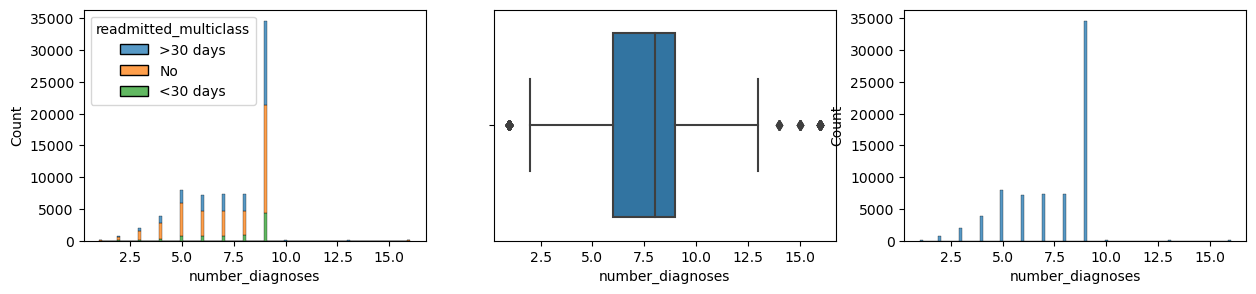

In [29]:
fig, ax =plt.subplots(1,3,figsize=(15, 3))
sns.histplot(data = df, x = 'number_diagnoses', hue = 'readmitted_multiclass', multiple= 'stack', ax=ax[0])
sns.histplot(data = df, x = 'number_diagnoses', ax=ax[2])
sns.boxplot(data = df, x = 'number_diagnoses', ax=ax[1])
fig.show()

## Categorical Features <a class="anchor" id="cat"></a>

#### race

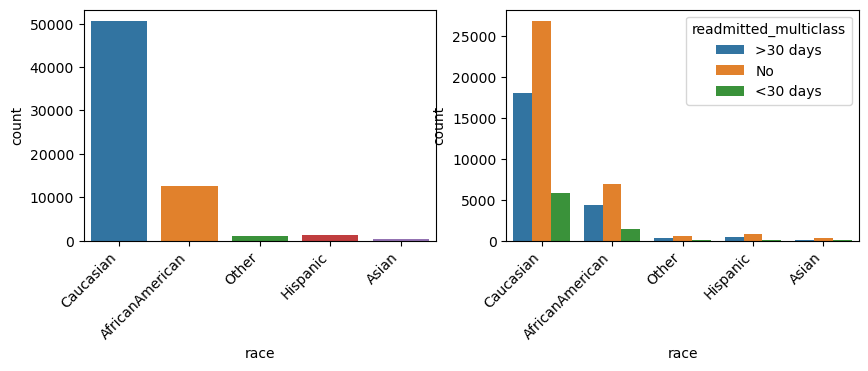

In [30]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'race', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'race', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### gender

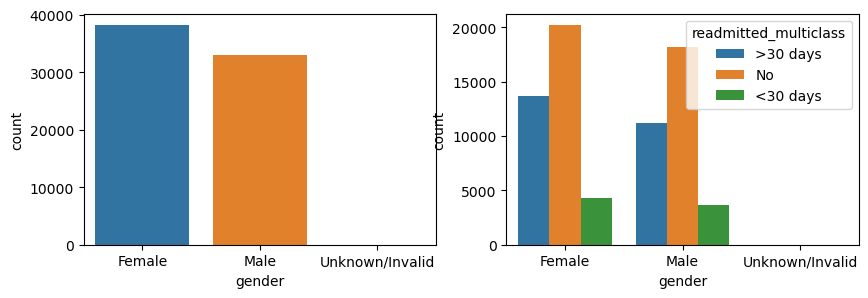

In [31]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'gender', ax=ax[0])
sns.countplot(data = df, x = 'gender', hue = 'readmitted_multiclass', ax=ax[1])
fig.show()

#### age

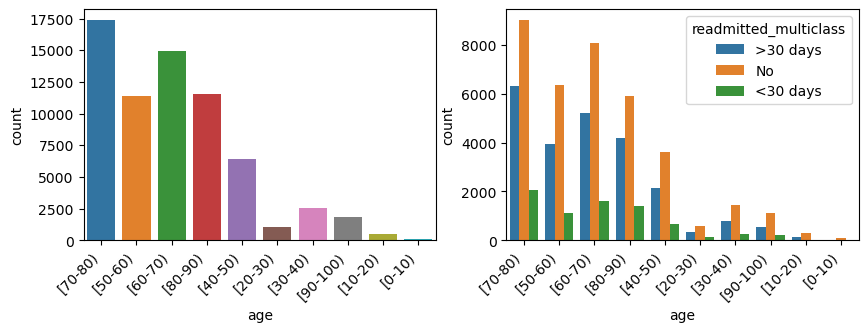

In [32]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'age', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'age', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### weight

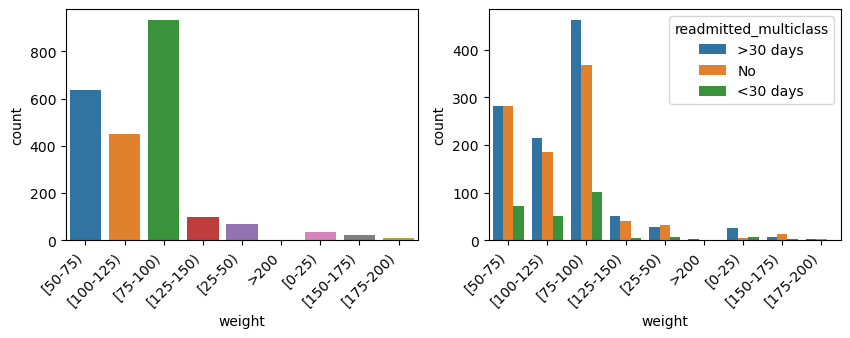

In [33]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'weight', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'weight', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### payer_code

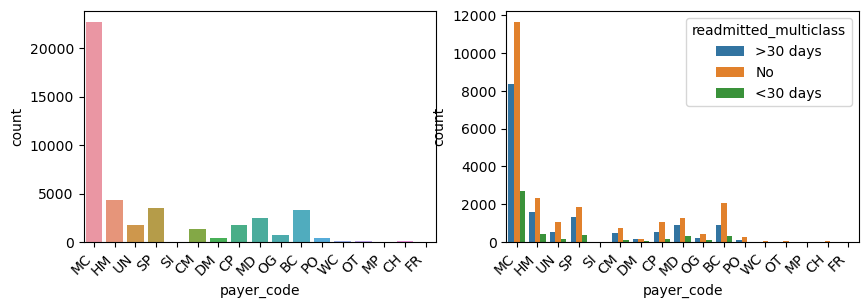

In [34]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'payer_code', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'payer_code', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### admission_type

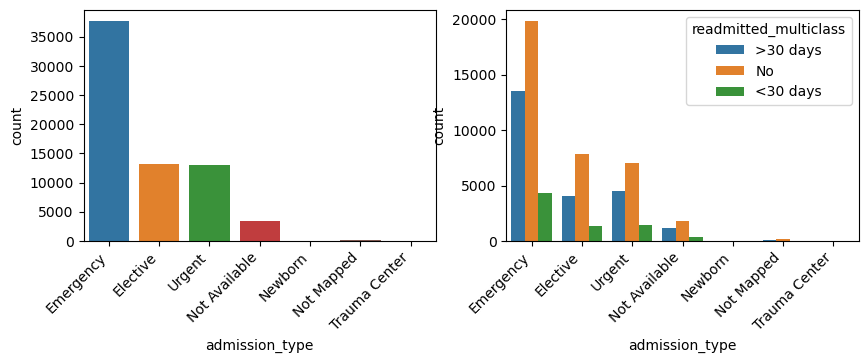

In [35]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'admission_type', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'admission_type', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### medical_specialty

In [36]:
df['medical_specialty'].value_counts(dropna = False)

medical_specialty
NaN                              34922
InternalMedicine                 10292
Emergency/Trauma                  5319
Family/GeneralPractice            5217
Cardiology                        3716
                                 ...  
Speech                               1
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Neurophysiology                      1
Name: count, Length: 69, dtype: int64

#### discharge_disposition

In [37]:
df['discharge_disposition'].value_counts(dropna = False)

discharge_disposition
Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
NaN                                                                                                           2590
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Expired                                                                                                       1135
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                

#### admission_source

In [38]:
df['admission_source'].value_counts(dropna = False)

admission_source
 Emergency Room                                               40319
 Physician Referral                                           20678
NaN                                                            4718
Transfer from a hospital                                       2230
 Transfer from another health care facility                    1562
Clinic Referral                                                 779
 Transfer from a Skilled Nursing Facility (SNF)                 595
HMO Referral                                                    129
 Not Mapped                                                     107
 Not Available                                                   88
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth              

#### primary_diagnosis

In [39]:
df['primary_diagnosis'].value_counts(dropna = False)

primary_diagnosis
428    4776
414    4596
786    2846
410    2513
486    2488
       ... 
412       1
375       1
147       1
422       1
299       1
Name: count, Length: 687, dtype: int64

#### secondary_diagnosis

In [40]:
df['secondary_diagnosis'].value_counts(dropna = False)

secondary_diagnosis
276     4694
428     4685
250     4257
427     3537
401     2624
        ... 
658        1
610        1
908        1
46         1
E968       1
Name: count, Length: 699, dtype: int64

#### additional_diagnosis

In [41]:
df['additional_diagnosis'].value_counts(dropna = False)

additional_diagnosis
250      8070
401      5784
276      3599
428      3240
427      2767
         ... 
250.3       1
930         1
811         1
E883        1
669         1
Name: count, Length: 747, dtype: int64

#### glucose_test_result

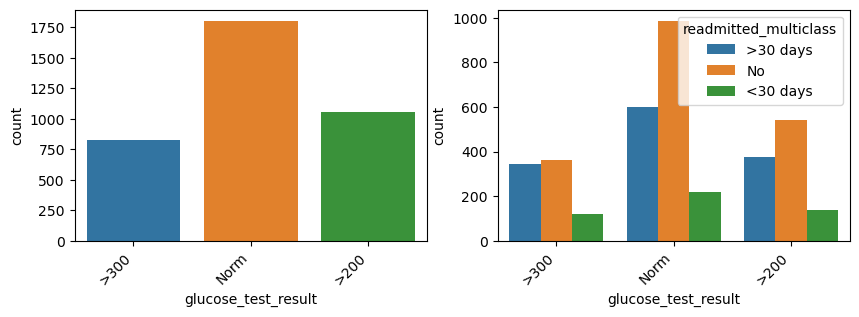

In [42]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'glucose_test_result', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'glucose_test_result', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### a1c_test_result

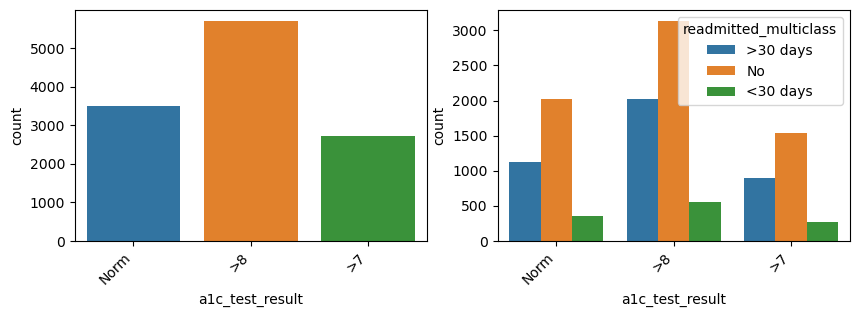

In [43]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'a1c_test_result', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'a1c_test_result', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### change_in_meds_during_hospitalization

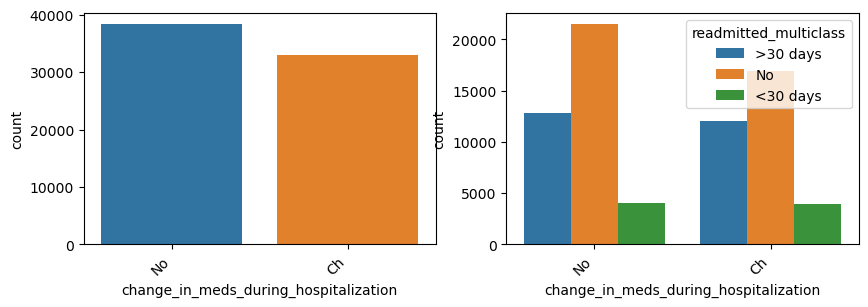

In [44]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'change_in_meds_during_hospitalization', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'change_in_meds_during_hospitalization', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### prescribed_diabetes_meds

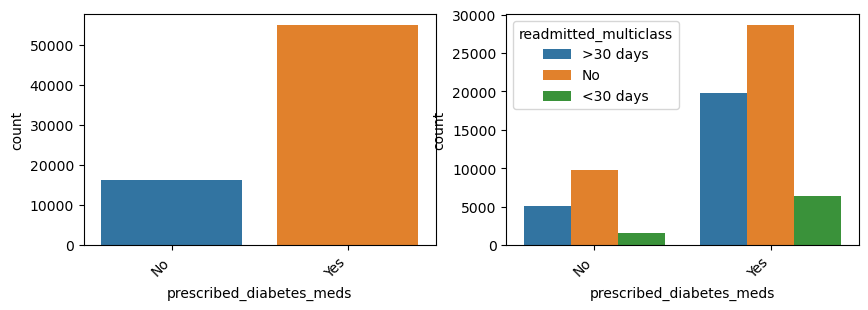

In [45]:
fig, ax =plt.subplots(1,2,figsize=(10, 3))
sns.countplot(data = df, x = 'prescribed_diabetes_meds', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
sns.countplot(data = df, x = 'prescribed_diabetes_meds', hue = 'readmitted_multiclass', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light')
ax[1].legend(title='readmitted_multiclass')
fig.show()

#### medication

In [46]:
df['medication'].value_counts(dropna = False)

medication
['insulin']                                                       21715
[]                                                                16346
['metformin']                                                      3152
['metformin', 'insulin']                                           3041
['glipizide']                                                      2727
                                                                  ...  
['pioglitazone', 'acarbose', 'insulin', 'glyburide-metformin']        1
['glimepiride', 'rosiglitazone', 'acarbose']                          1
['glipizide', 'pioglitazone', 'acarbose', 'insulin']                  1
['metformin', 'glyburide', 'acarbose', 'insulin']                     1
['glimepiride', 'rosiglitazone', 'miglitol', 'insulin']               1
Name: count, Length: 303, dtype: int64

#### readmitted_multiclass

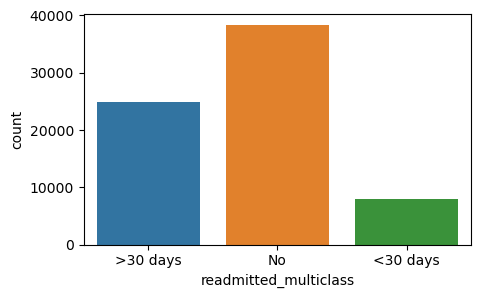

In [47]:
fig, ax =plt.subplots(1,1,figsize=(5, 3))
sns.countplot(data = df, x = 'readmitted_multiclass')
fig.show()

#### patient_id

In [48]:
train["patient_id"]

encounter_id
533253       70110
426224    29775006
634063    80729253
890610     2919042
654194    84871971
            ...   
660160    24531381
826429     4663818
332030    23397147
757560    52161750
459757    88410897
Name: patient_id, Length: 71236, dtype: int64

In [49]:
repeated_values = train['patient_id'].value_counts()
repeated_values = repeated_values[repeated_values > 1]
print(repeated_values)

patient_id
88785891     33
1660293      19
84428613     18
37096866     17
23199021     15
             ..
105797601     2
3446118       2
105263262     2
109114137     2
59142753      2
Name: count, Length: 10559, dtype: int64


In [50]:
train[(train['discharge_disposition']=="Hospice / home") & (train["readmitted_binary"]=="Yes")]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
369573,USA,93854601,Caucasian,Male,[80-90),[50-75),CM,0,0,0,...,784,E934,9,NaN,NaN,No,No,[],Yes,<30 days
317759,USA,8767800,Caucasian,Male,[70-80),NaN,NaN,0,0,0,...,428,426,7,NaN,NaN,No,Yes,['glyburide'],Yes,<30 days
969527,USA,12811878,Caucasian,Female,[80-90),NaN,NaN,12,2,6,...,518,585,9,NaN,NaN,No,Yes,['insulin'],Yes,<30 days
244648,USA,95075865,Caucasian,Male,[60-70),NaN,MD,3,4,0,...,599,198,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days
936958,USA,23717187,AfricanAmerican,Female,[90-100),NaN,MC,0,1,2,...,425,V66,6,NaN,NaN,No,Yes,['metformin'],Yes,<30 days
516866,USA,34301979,Caucasian,Male,[70-80),NaN,MC,0,1,1,...,707,263,9,NaN,NaN,No,No,[],Yes,<30 days
252583,USA,95060412,Caucasian,Female,[80-90),NaN,MC,0,0,0,...,789,332,9,NaN,NaN,No,Yes,['insulin'],Yes,<30 days
660381,USA,66776904,Caucasian,Female,[70-80),NaN,NaN,0,0,3,...,428,403,9,NaN,NaN,No,Yes,['glyburide'],Yes,<30 days
679728,USA,111138912,AfricanAmerican,Male,[60-70),NaN,NaN,0,0,1,...,157,199,8,NaN,NaN,Ch,Yes,"['pioglitazone', 'insulin']",Yes,<30 days


In [51]:
train[train["readmitted_binary"]=="Yes"]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
345921,USA,63536886,Caucasian,Male,[80-90),NaN,NaN,0,0,0,...,403,428,7,NaN,NaN,Ch,Yes,"['glipizide', 'insulin']",Yes,<30 days
873304,USA,23492133,AfricanAmerican,Female,[60-70),NaN,NaN,0,0,0,...,403,496,8,NaN,NaN,No,No,[],Yes,<30 days
102821,USA,30520872,Caucasian,Female,[60-70),NaN,MC,0,0,1,...,682,428,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days
844139,USA,24854895,Caucasian,Male,NaN,NaN,NaN,0,0,1,...,491,682,9,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
825255,USA,3509442,Caucasian,Male,[50-60),NaN,NaN,0,0,1,...,996,433,9,NaN,NaN,No,No,[],Yes,<30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259379,USA,29662614,Caucasian,Female,[60-70),NaN,MC,4,0,0,...,518,569,9,NaN,NaN,Ch,Yes,"['metformin', 'pioglitazone', 'insulin']",Yes,<30 days
631066,USA,24858882,Caucasian,Male,[70-80),NaN,MC,0,0,0,...,276,536,9,NaN,NaN,Ch,Yes,"['metformin', 'insulin']",Yes,<30 days
397846,USA,57184236,Caucasian,Female,[80-90),NaN,MC,0,0,2,...,434,250.02,9,NaN,NaN,No,Yes,['insulin'],Yes,<30 days


In [52]:
train[(train['glucose_test_result']==">300")& (train["readmitted_binary"]=="Yes")]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
844139,USA,24854895,Caucasian,Male,NaN,NaN,NaN,0,0,1,...,491,682,9,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
844722,USA,23619924,Caucasian,Female,[70-80),NaN,NaN,0,0,0,...,401,250,4,>300,NaN,Ch,Yes,"['metformin', 'pioglitazone', 'insulin']",Yes,<30 days
335808,USA,23661198,Caucasian,Male,[50-60),NaN,MC,1,0,0,...,428,424,9,>300,NaN,Ch,Yes,"['metformin', 'glipizide', 'rosiglitazone', 'i...",Yes,<30 days
283073,USA,25841151,AfricanAmerican,Male,[40-50),NaN,NaN,1,0,0,...,250.03,401,6,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
333098,USA,24209856,Caucasian,Female,NaN,NaN,MD,0,1,3,...,70,303,8,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578889,USA,25869789,Caucasian,Male,NaN,NaN,NaN,1,2,0,...,491,276,7,>300,NaN,Ch,Yes,"['glipizide', 'insulin']",Yes,<30 days
864300,USA,23643405,Caucasian,Female,[20-30),NaN,HM,0,4,13,...,250.41,578,7,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days
846465,USA,24269553,Caucasian,Male,NaN,NaN,NaN,1,3,1,...,250.01,278,9,>300,NaN,Ch,Yes,['insulin'],Yes,<30 days


In [53]:
train[(train['glucose_test_result']=="Norm")& (train["readmitted_binary"]=="Yes")]

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
891370,USA,23382351,Caucasian,Female,[80-90),NaN,MC,2,0,0,...,401,250,4,Norm,NaN,Ch,Yes,"['glyburide', 'insulin']",Yes,<30 days
754155,USA,54026280,Hispanic,Female,[60-70),NaN,NaN,0,0,0,...,562,535,6,Norm,NaN,No,No,[],Yes,<30 days
925506,USA,95930262,Caucasian,Female,[70-80),NaN,NaN,0,0,1,...,780,780,6,Norm,NaN,No,Yes,['glyburide'],Yes,<30 days
593152,USA,23512842,Caucasian,Female,[80-90),NaN,NaN,0,0,2,...,428,496,9,Norm,NaN,Ch,Yes,['insulin'],Yes,<30 days
732548,USA,99421578,Caucasian,Female,[90-100),NaN,HM,1,1,0,...,578,427,9,Norm,NaN,No,No,[],Yes,<30 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802711,USA,4778442,AfricanAmerican,Female,[70-80),NaN,NaN,0,0,0,...,250,401,3,Norm,NaN,No,Yes,['insulin'],Yes,<30 days
289939,USA,23393988,Caucasian,Male,[70-80),NaN,NaN,3,0,1,...,511,496,8,Norm,NaN,No,Yes,['glipizide'],Yes,<30 days
819403,USA,23378175,Caucasian,Female,[50-60),NaN,NaN,0,0,0,...,276,465,8,Norm,NaN,No,Yes,['metformin'],Yes,<30 days


# Preprocessing steps <a class="anchor" id="preprocessing"></a>

## Incoherences <a class="anchor" id="incoherences"></a>

In [54]:
# Newborns with incorrect ages

age_to_exclude = ['[70-80)', '[50-60)', '[60-70)', '[80-90)', '[40-50)', '[20-30)', '[30-40)', '[90-100)', '[10-20)']

train = train.drop(train[(train["admission_type"] == "Newborn") & (train["age"].isin(age_to_exclude))].index)

In [55]:
# We will group the discharge_disposition later, so we decided to drop discharge_disposition with Expired

discharge_to_exclude = [
    'Expired',
    'Expired at home. Medicaid only, hospice.',
    'Expired in a medical facility. Medicaid only, hospice.'
]

train = train[~train['discharge_disposition'].isin(discharge_to_exclude)]

In [56]:
# Drop the gender with "Unknown/Invalid"

train = train[train['gender'] != "Unknown/Invalid"]

In [57]:
# Drop the Sick Baby and Extramural Birth with incorrect age

train = train[train['admission_source']!=" Sick Baby"]
train = train[train['admission_source']!=' Extramural Birth']

In [58]:
train.shape[0]/71236

0.9838284013700938

## Outliers <a class="anchor" id="outliers"></a>

In [59]:
numerical_features = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']
categorical_features = train.columns.drop(numerical_features).to_list()

In [60]:
train[numerical_features].kurt() # a distribuição normal pela kurtose é evbidenciada quando a mesma é 3
# pelo que só vamos tomar atenção a valores superiores a 3 (n vemos o "number_od_medications" pq é mt proximo de 3 e é quase uma distribuição normal)

outpatient_visits_in_previous_year     154.037224
emergency_visits_in_previous_year     1210.468503
inpatient_visits_in_previous_year       20.386848
average_pulse_bpm                       -1.189798
length_of_stay_in_hospital               0.862472
number_lab_tests                        -0.264841
non_lab_procedures                       0.887171
number_of_medications                    3.512509
number_diagnoses                        -0.097114
dtype: float64

In [61]:
train[(train["outpatient_visits_in_previous_year"]>22) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 23

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
472104,USA,1978605,Caucasian,Female,[50-60),NaN,NaN,23,0,2,...,997,250.02,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days


In [62]:
train[(train["inpatient_visits_in_previous_year"]>20) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 21

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
357915,USA,4790016,Caucasian,Female,[20-30),[50-75),MC,0,1,21,...,577,309,7,NaN,NaN,No,Yes,['insulin'],Yes,<30 days


In [63]:
train[(train["emergency_visits_in_previous_year"]>27) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 28

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
641150,USA,5539599,Caucasian,Male,[50-60),NaN,NaN,2,28,5,...,682,844,6,NaN,>7,No,No,[],Yes,<30 days


In [64]:
train[(train["number_of_medications"]>69) & (train["readmitted_binary"]=="Yes")] # threshold = maior q 70

,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,
128311,USA,25162767,AfricanAmerican,Female,[50-60),NaN,SP,0,0,0,...,584,427,9,NaN,NaN,Ch,Yes,['insulin'],Yes,<30 days


In [65]:
# Alteração ao dataset ( remover outliers )

# Basicamente aqui aplicamos o método windsorizing manualmente, dps das análises gráficas ( explicar o que faz este método no report )

# aplicamos manuamente ºpq neste projeto a dificuldade é descobrir quem volta e aplicando os thresholds escolhidos conseguimos treinar melhor o modelo para esse aspeto

train.loc[train["outpatient_visits_in_previous_year"]>23, "outpatient_visits_in_previous_year"] = 24

train.loc[train["inpatient_visits_in_previous_year"]>21, "inpatient_visits_in_previous_year"] = 22

train.loc[train["emergency_visits_in_previous_year"]>28, "emergency_visits_in_previous_year"] = 29

## Missing Values <a class="anchor" id="miss"></a>

In [66]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                      4989
gender                                       0
age                                       3506
weight                                   67869
payer_code                               27750
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3659
medical_specialty                        34339
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4630
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           16
secondary_diagnosis                        262
additional_di

In [67]:
# We will keep "race" and fill the missing values with mode

train["race"].value_counts()

race
Caucasian          49862
AfricanAmerican    12483
Hispanic            1351
Other                983
Asian                416
Name: count, dtype: int64

In [68]:
# We will keep "age" and fill the missing values with mode

train["age"].value_counts()

age
[70-80)     17016
[60-70)     14704
[50-60)     11321
[80-90)     11183
[40-50)      6382
[30-40)      2529
[90-100)     1799
[20-30)      1067
[10-20)       473
[0-10)        104
Name: count, dtype: int64

In [69]:
# We will drop "weight" but we are doing a binary feature as missing values or not

In [70]:
# https://www.mass.gov/doc/hsn-payer-code-list20130118pdf/download
# Payer_Code -> Code of the health insurance provider (if there is one)
# So this Nan values we need to input with SP = Self Payed

train["payer_code"].value_counts()

payer_code
MC    22202
HM     4279
SP     3503
BC     3270
MD     2453
CP     1732
UN     1713
CM     1326
OG      721
PO      400
DM      375
CH      101
WC       99
OT       60
MP       54
SI       45
FR        1
Name: count, dtype: int64

In [71]:
# We will keep "admission_type" and fill the missing values with mode

train["admission_type"].value_counts()

admission_type
Emergency        36973
Elective         13115
Urgent           12848
Not Available     3262
Not Mapped         214
Trauma Center       12
Newborn              1
Name: count, dtype: int64

In [72]:
# We will keep "medical_specialty" and fill the missing values with "Other"

train["medical_specialty"].value_counts()

medical_specialty
InternalMedicine                 10090
Emergency/Trauma                  5237
Family/GeneralPractice            5122
Cardiology                        3675
Surgery-General                   2120
                                 ...  
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Pediatrics-EmergencyMedicine         1
Neurophysiology                      1
Name: count, Length: 68, dtype: int64

In [73]:
# We will keep "discharge_disposition" and fill the missing values with mode

train["discharge_disposition"].value_counts()

discharge_disposition
Discharged to home                                                                                           42249
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9003
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1392
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                                                                                  571
Left AMA                                                  

In [74]:
# We will keep "admission_source" and fill the missing values with mode

train["admission_source"].value_counts()

admission_source
 Emergency Room                                               39534
 Physician Referral                                           20505
Transfer from a hospital                                       2188
 Transfer from another health care facility                    1545
Clinic Referral                                                 767
 Transfer from a Skilled Nursing Facility (SNF)                 566
HMO Referral                                                    127
 Not Mapped                                                     106
 Not Available                                                   88
 Court/Law Enforcement                                           10
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                                   1
Name: count, dtype: int64

In [75]:
# We will keep "primary_diagnosis" and fill the missing values with mode

train["primary_diagnosis"].value_counts()

primary_diagnosis
428    4683
414    4573
786    2846
410    2418
486    2416
       ... 
147       1
422       1
219       1
875       1
299       1
Name: count, Length: 684, dtype: int64

In [76]:
# We will keep "secondary_diagnosis" and fill the missing values with "primary_diagnosis" mode to keep consistency

train["secondary_diagnosis"].value_counts()

secondary_diagnosis
276     4622
428     4596
250     4247
427     3458
401     2617
        ... 
916        1
833        1
E868       1
944        1
E968       1
Name: count, Length: 697, dtype: int64

In [77]:
# We will keep "additional_diagnosis" and fill the missing values with "primary_diagnosis" mode to keep consistency

train["additional_diagnosis"].value_counts()

additional_diagnosis
250     8027
401     5747
276     3495
428     3160
427     2684
        ... 
E892       1
602        1
164        1
597        1
669        1
Name: count, Length: 744, dtype: int64

In [78]:
# We will drop 'glucose_test_result' and 'a1c_test_result' but we are doing a binary feature as missing values or not

In [79]:
# race

train["race"] = train["race"].replace(np.nan, train["race"].mode()[0])
test["race"] = test["race"].replace(np.nan, test["race"].mode()[0])

# age

train["age"] = train["age"].replace(np.nan, train["age"].mode()[0])
test["age"] = test["age"].replace(np.nan, test["age"].mode()[0])

# payer_code

train["payer_code"] = train["payer_code"].replace(np.nan, "SP")
test["payer_code"] = test["payer_code"].replace(np.nan, "SP")

# admission_type

train["admission_type"] = train["admission_type"].replace(np.nan, "Not Available")
test["admission_type"] = test["admission_type"].replace(np.nan, "Not Available")

# medical_specialty

train["medical_specialty"] = train["medical_specialty"].replace(np.nan, "Other")
test["medical_specialty"] = test["medical_specialty"].replace(np.nan, "Other")

# discharge_disposition

train["discharge_disposition"] = train["discharge_disposition"].replace(np.nan, "Not Available")
test["discharge_disposition"] = test["discharge_disposition"].replace(np.nan, "Not Available")

# admission_source

train["admission_source"] = train["admission_source"].replace(np.nan, "Not Available")
test["admission_source"] = test["admission_source"].replace(np.nan, "Not Available")

# primary_diagnosis

train["primary_diagnosis"] = train["primary_diagnosis"].replace(np.nan, train["primary_diagnosis"].mode()[0])
test["primary_diagnosis"] = test["primary_diagnosis"].replace(np.nan, test["primary_diagnosis"].mode()[0])

# secondary_diagnosis

train["secondary_diagnosis"] = train["secondary_diagnosis"].replace(np.nan, train["secondary_diagnosis"].mode()[0])
test["secondary_diagnosis"] = test["secondary_diagnosis"].replace(np.nan, test["secondary_diagnosis"].mode()[0])

# additional_diagnosis

train["additional_diagnosis"] = train["additional_diagnosis"].replace(np.nan, train["additional_diagnosis"].mode()[0])
test["additional_diagnosis"] = test["additional_diagnosis"].replace(np.nan, test["additional_diagnosis"].mode()[0])

In [80]:
train.loc[353655]

country                                                  USA
patient_id                                          28219392
race                                               Caucasian
gender                                                Female
age                                                  [60-70)
weight                                             [100-125)
payer_code                                                MC
outpatient_visits_in_previous_year                         1
emergency_visits_in_previous_year                          0
inpatient_visits_in_previous_year                          0
admission_type                                        Urgent
medical_specialty                           InternalMedicine
average_pulse_bpm                                        121
discharge_disposition                     Discharged to home
admission_source                          Physician Referral
length_of_stay_in_hospital                                 3
number_lab_tests        

In [81]:
test["primary_diagnosis"].value_counts()

primary_diagnosis
428    2091
414    1985
786    1170
410    1101
486    1020
       ... 
804       1
990       1
833       1
653       1
867       1
Name: count, Length: 594, dtype: int64

In [82]:
train.isna().sum()

country                                      0
patient_id                                   0
race                                         0
gender                                       0
age                                          0
weight                                   67869
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                               0
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                        0
admission_source                             0
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

In [83]:
test.isna().sum()

country                                      0
patient_id                                   0
race                                         0
gender                                       0
age                                          0
weight                                   29579
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                               0
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                        0
admission_source                             0
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

## Feature Engineering <a class="anchor" id="feature_eng"></a>

In [84]:
# Log transforamtion to get better distributions

In [85]:
train['log_outpatient_visits_in_previous_year'] = np.log1p(train['outpatient_visits_in_previous_year'])
test['log_outpatient_visits_in_previous_year'] = np.log1p(test['outpatient_visits_in_previous_year'])

In [86]:
train['log_emergency_visits_in_previous_year'] = np.log1p(train['emergency_visits_in_previous_year'])
test['log_emergency_visits_in_previous_year'] = np.log1p(test['emergency_visits_in_previous_year'])

In [87]:
train['log_inpatient_visits_in_previous_year'] = np.log1p(train['inpatient_visits_in_previous_year'])
test['log_inpatient_visits_in_previous_year'] = np.log1p(test['inpatient_visits_in_previous_year'])

In [88]:
# "visits_in_previous_year" -> sum of all patient visit in previous year

train["visits_in_previous_year"] = train["outpatient_visits_in_previous_year"] + train["emergency_visits_in_previous_year"] + train["inpatient_visits_in_previous_year"]
test["visits_in_previous_year"] = test["outpatient_visits_in_previous_year"] + test["emergency_visits_in_previous_year"] + test["inpatient_visits_in_previous_year"]

In [89]:
train.isna().sum()

country                                       0
patient_id                                    0
race                                          0
gender                                        0
age                                           0
weight                                    67869
payer_code                                    0
outpatient_visits_in_previous_year            0
emergency_visits_in_previous_year             0
inpatient_visits_in_previous_year             0
admission_type                                0
medical_specialty                             0
average_pulse_bpm                             0
discharge_disposition                         0
admission_source                              0
length_of_stay_in_hospital                    0
number_lab_tests                              0
non_lab_procedures                            0
number_of_medications                         0
primary_diagnosis                             0
secondary_diagnosis                     

In [90]:
# "'medication_'+mclass" -> all medications in binary features

train['medication'] = train['medication'].apply(lambda x: ast.literal_eval(x))

test['medication'] = test['medication'].apply(lambda x: ast.literal_eval(x))

med_list = []
for i in range(len(train)):
    med_list.append(train.medication.iloc[i])

med_classes = np.unique([num for elem in med_list for num in elem])

for mclass in med_classes:
    train['medication_'+mclass] = train['medication'].apply(lambda x: 1 if mclass in x else 0)

    test['medication_'+mclass] = test['medication'].apply(lambda x: 1 if mclass in x else 0)


In [91]:
# make a feature named weight filling missing values with mode

In [92]:
# 'weight_bin' -> binary feature 1 if the patient has weight record else 0

train['weight_bin'] = train['weight'].notna().astype(int)

test['weight_bin'] = test['weight'].notna().astype(int)

In [93]:
# "test_result" -> 1 if respects the conditions else 0

conditions_train = (
    (train['a1c_test_result'] == '>7') |
    (train['a1c_test_result'] == '>8') |
    (train['glucose_test_result'] == '>200') |
    (train['glucose_test_result'] == '>300')
)

train['test_result'] = conditions_train.astype(int)

conditions_test = (
    (test['a1c_test_result'] == '>7') |
    (test['a1c_test_result'] == '>8') |
    (test['glucose_test_result'] == '>200') |
    (test['glucose_test_result'] == '>300')
)

test['test_result'] = conditions_test.astype(int)

In [94]:
# "regular patient" -> 1 if patient_id is repeated in the data else 0

train['regular_patient'] = train.groupby('patient_id')['patient_id'].transform('count') > 1
train['regular_patient'] = train['regular_patient'].astype(int)

test['regular_patient'] = test.groupby('patient_id')['patient_id'].transform('count') > 1
test['regular_patient'] = test['regular_patient'].astype(int)

In [95]:
# "gender_bin" -> 1 if its Female else 0

train['gender_bin'] = (train['gender'] == 'Female').astype(int)

test['gender_bin'] = (test['gender'] == 'Female').astype(int)

In [96]:
# "change_in_meds_during_hospitalization_bin" -> 1 if it changes else 0

train['change_in_meds_during_hospitalization_bin'] = (train['change_in_meds_during_hospitalization'] == 'Ch').astype(int)

test['change_in_meds_during_hospitalization_bin'] = (test['change_in_meds_during_hospitalization'] == 'Ch').astype(int)

In [97]:
# "prescribed_diabetes_meds_bin" -> 1 if it has meds else 0

train['prescribed_diabetes_meds_bin'] = (train['prescribed_diabetes_meds'] == 'Yes').astype(int)

test['prescribed_diabetes_meds_bin'] = (test['prescribed_diabetes_meds'] == 'Yes').astype(int)

In [98]:
# "readmitted_binary" -> 1 if it Yes else 0

train['readmitted_binary'] = (train['readmitted_binary'] == 'Yes').astype(int)

In [99]:
# Drop irrelevant features

features_to_drop = ["country", "patient_id", "gender", "weight", "medication", "glucose_test_result", "a1c_test_result", "change_in_meds_during_hospitalization","prescribed_diabetes_meds","outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year"]

train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

## Encoding and Grouping <a class="anchor" id="enc"></a>

In [100]:
# Mapping race

race_mapping = {
    'Caucasian': 0,
    'AfricanAmerican': 1,
    'Hispanic': 2,
    'Other': 3,
    'Asian': 4
}

train['race'] = train['race'].map(race_mapping)

test['race'] = test['race'].map(race_mapping)

In [101]:
# Mapping "age"

age_mapping = {"[0-10)": 5,
               '[10-20)': 15,
               '[20-30)': 25,
               '[30-40)': 35,
               '[40-50)': 45,
               '[50-60)': 55,
               '[60-70)': 65,
               '[70-80)': 75,
               '[80-90)': 85,
               '[90-100)': 95}

train['age'] = train['age'].map(age_mapping)

test['age'] = test['age'].map(age_mapping)

In [102]:
train["payer_code"].value_counts()

payer_code
SP    31253
MC    22202
HM     4279
BC     3270
MD     2453
CP     1732
UN     1713
CM     1326
OG      721
PO      400
DM      375
CH      101
WC       99
OT       60
MP       54
SI       45
FR        1
Name: count, dtype: int64

In [103]:
# Mapping payer_code
# https://www.mass.gov/doc/hsn-payer-code-list20130118pdf/download

payer_code_mapping = {"SP": 0,
              "MC": 1,
              "HM": 2,
              "BC": 3,
              "MD": 4,
              "CP": 5,
              "UN": 6,
              "CM": 7,
              "OG": 8,
              "PO": 8,
              "DM": 8,
              "CH": 8,
              "WC": 8,
              "OT": 8,
              "MP": 8,
              "SI": 8,
              "FR": 8}

train['payer_code'] = train['payer_code'].map(payer_code_mapping)

test['payer_code'] = test['payer_code'].map(payer_code_mapping)

In [104]:
train["admission_type"].value_counts()

admission_type
Emergency        36973
Elective         13115
Urgent           12848
Not Available     6921
Not Mapped         214
Trauma Center       12
Newborn              1
Name: count, dtype: int64

In [105]:
# Mapping admission_type

admission_type_mapping = {
                          "Emergency": 0,
                          "Elective": 1,
                          "Urgent": 2,
                          "Not Available": 3,
                          "Not Mapped": 3,
                          "Trauma Center": 4,
                          "Newborn": 5,
                          }

train['admission_type'] = train['admission_type'].map(admission_type_mapping)

test['admission_type'] = test['admission_type'].map(admission_type_mapping)

In [106]:
# Mapping medical_specialty
# https://run.unl.pt/bitstream/10362/145706/1/TGI1636.pdf

# AllergyandImmunology -> Allergy and Immunology = 0
# Pathology -> Anatomic and Clinical Pathology = 1
# Anesthesiology, Anesthesiology-Pediatric -> Anesthesiology = 2
# Dermatology -> Dermatology = 3
# Radiologist, Radiology -> Diagnostic Radiology = 4
# Emergency, Trauma -> Emergency Medicine = 5
# Family, GeneralPractice -> Family, GeneralPractice = 6
# Surgery-PlasticwithinHeadandNeck, Surgeon, Surgery-Cardiovascular, Surgery-Cardiovascular/Thoracic, SurgeryColon&Rectal, Surgery-General, Surgery-Maxillofacial, Surgery-Neuro, SurgeryPediatric, Surgery-Plastic, Surgery-Thoracic, Surgery-Vascular, SurgicalSpecialty -> General Surgery = 7
# Cardiology, DCPTEAM, Endocrinology, Endocrinology-Metabolism, Gastroenterology, Hematology, Hematology/Oncology, Hospitalist, InfectiousDiseases, InternalMedicine, Nephrology, Neurophysiology, Oncology, Proctology, Pulmonology, Rheumatology, SportsMedicine, Urology -> Internal medicine = 8
# Neurology -> Neurology = 9
# Gynecology, Obsterics&Gynecology-GynecologicOnco, Obstetrics,ObstetricsandGynecology -> Obstetrics and Gynecology = 10
# Ophthalmology -> Ophthalmology = 11
# Orthopedics, Orthopedics-Reconstructive -> Orthopaedic Surgery = 12
# Osteopath -> Osteopathic Neuromusculoskeletal Medicine = 13
# Dentistry, Podiatry, Psychology, Resident, Speech -> Other Healthcare Practitioners = 14
# Otolaryngology -> Otolaryngology-Head and Neck Surgery = 15
# Cardiology-Pediatric, Pediatrics, Pediatrics-AllergyandImmunology, PediatricsCriticalCare, Pediatrics-EmergencyMedicine, Pediatrics-Endocrinology, PediatricsHematology-Oncology, Pediatrics-InfectiousDiseases, Pediatrics-Neurology, PediatricsPulmonology, Perinatology, Psychiatry-Child/Adolescent -> Pediatrics = 16
# PhysicalMedicineandRehabilitation, PhysicianNotFound -> Physical Medicine and Rehabilitation = 17
# Psychiatry, Psychiatry-Addictive -> Psychiatry= 18
# OutreachServices -> Other = 19
medical_specialty_mapping = {
                                "AllergyandImmunology":0,
                                "Pathology":1,
                                "Anesthesiology":2,
                                "Anesthesiology-Pediatric":2,
                                "Dermatology ":3,
                                'Dermatology':3,
                                "Radiologist":4,
                                "Radiology":4,
                                "Emergency/Trauma":5,
                                "Family/GeneralPractice":6,
                                "Surgeon":7,
                                "Surgery-Cardiovascular":7,
                                "Surgery-Cardiovascular/Thoracic":7,
                                "Surgery-Colon&Rectal":7,
                                "Surgery-General":7,
                                "Surgery-Maxillofacial":7,
                                "Surgery-Neuro":7,
                                "Surgery-Pediatric":7,
                                "Surgery-Plastic":7,
                                "Surgery-Thoracic":7,
                                "Surgery-Vascular":7,
                                "SurgicalSpecialty":7,
                                "Surgery-PlasticwithinHeadandNeck":7,
                                "Cardiology":8,
                                "DCPTEAM":8,
                                "Endocrinology":8,
                                "Endocrinology-Metabolism":8,
                                "Gastroenterology":8,
                                "Hematology":8,
                                "Hematology/Oncology":8,
                                "Hospitalist":8,
                                "InfectiousDiseases":8,
                                "InternalMedicine":8,
                                "Nephrology":8,
                                "Neurophysiology":8,
                                "Oncology":8,
                                "Proctology":8,
                                "Pulmonology":8,
                                "Rheumatology":8,
                                "SportsMedicine":8,
                                "Urology":8,
                                "Neurology":9,
                                "Gynecology":10,
                                "Obsterics&Gynecology-GynecologicOnco":10,
                                "Obstetrics":10,
                                "ObstetricsandGynecology":10,
                                "Ophthalmology":11,
                                "Orthopedics":12,
                                "Orthopedics-Reconstructive":12,
                                "Osteopath":13,
                                "Dentistry":14,
                                "Podiatry":14,
                                "Psychology":14,
                                "Resident":14,
                                "Speech":14,
                                "Otolaryngology":15,
                                "Cardiology-Pediatric":16,
                                "Pediatrics":16,
                                "Pediatrics-AllergyandImmunology":16,
                                "Pediatrics-CriticalCare":16,
                                "Pediatrics-EmergencyMedicine":16,
                                "Pediatrics-Endocrinology":16,
                                "Pediatrics-Hematology-Oncology":16,
                                "Pediatrics-InfectiousDiseases":16,
                                "Pediatrics-Neurology":16,
                                "Pediatrics-Pulmonology":16,
                                "Perinatology":16,
                                "Psychiatry-Child/Adolescent":16,
                                "PhysicalMedicineandRehabilitation":17,
                                "PhysicianNotFound":17,
                                "Psychiatry":18,
                                "Psychiatry-Addictive":18,
                                "Other":19,
                                "OutreachServices":19

                          }

train['medical_specialty'] = train['medical_specialty'].map(medical_specialty_mapping)

test['medical_specialty'] = test['medical_specialty'].map(medical_specialty_mapping) # notebook is buging here!

In [107]:
train["discharge_disposition"].value_counts()

discharge_disposition
Discharged to home                                                                                           42249
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9003
Not Available                                                                                                 2590
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1392
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                             

In [108]:
# Mapping discharge_disposition

# Discharged to home = 0

# Transferred to another medical facility = 1

# Left AMA(Against Medical Advice.) = 2

# Still patient/referred to this institution= 3

# Not Available = 4

# Hospice = 5

# Expired = 6

discharge_disposition_mapping = {
                                "Discharged to home":0,
                                "Discharged/transferred to home with home health service":0,
                                "Discharged/transferred to home under care of Home IV provider":0,
                                "Discharged/transferred to a federal health care facility.":1,
                                "Discharged/transferred to SNF":1,
                                "Discharged/transferred to another short term hospital":1,
                                "Discharged/transferred to ICF":1,
                                "Discharged/transferred to another rehab fac including rehab units of a hospital .":1,
                                "Discharged/transferred to a long term care hospital.":1,
                                "Discharged/transferred to another type of inpatient care institution":1,
                                "Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital":1,
                                "Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.":1,
                                "Discharged/transferred/referred another institution for outpatient services":1,
                                'Neonate discharged to another hospital for neonatal aftercare':1,
                                "Left AMA":2,
                                "Admitted as an inpatient to this hospital":3,
                                "Still patient or expected to return for outpatient services":3,
                                "Discharged/transferred within this institution to Medicare approved swing bed":3,
                                "Discharged/transferred/referred to this institution for outpatient services":3,
                                'Not Mapped':4,
                                "Not Available":4,
                                'Hospice / home':5,
                                'Hospice / medical facility':5,
                                'Expired':6,
                                'Expired at home. Medicaid only, hospice.':6,
                                'Expired in a medical facility. Medicaid only, hospice.':6

                                }

train['discharge_disposition'] = train['discharge_disposition'].map(discharge_disposition_mapping)

test['discharge_disposition'] = test['discharge_disposition'].map(discharge_disposition_mapping)

In [109]:
# Mapping admission_source

# Emergency Room = 0
# Referral -> A written order from your primary care doctor for you to see a specialist or get certain medical services
# Referral = 1
# from hospital = 2
# Court/Law Enforcement = 3
# Not Mapped = 4
# from Critical acess = 5
# Sick baby = 6
# Normal delivery = 7
admission_source_mapping = {
                                ' Emergency Room':0,
                                'Clinic Referral':1,
                                'HMO Referral':1,
                                ' Physician Referral':1,
                                ' Transfer from another health care facility':2,
                                'Transfer from a hospital':2,
                                ' Transfer from a Skilled Nursing Facility (SNF)':2,
                                ' Transfer from hospital inpt/same fac reslt in a sep claim':2,
                                ' Court/Law Enforcement':3,
                                ' Not Available':4,
                                "Not Available":4,
                                ' Not Mapped':4,
                                ' Transfer from critial access hospital':5,
                                ' Transfer from Ambulatory Surgery Center':5,
                                " Sick Baby":6,
                                ' Extramural Birth':6,
                                "Normal Delivery":7,
                            }

train['admission_source'] = train['admission_source'].map(admission_source_mapping)

test['admission_source'] = test['admission_source'].map(admission_source_mapping)

In [110]:
# Mapping primary_diagnosis, secondary_diagnosis and additional_diagnosis

In [111]:
# Replace values starting with 'V' with -9999
train['primary_diagnosis'] = train['primary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)

# Replace values starting with 'V' with -9999
test['primary_diagnosis'] = test['primary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(lambda x: -9999 if str(x).startswith('V') else x)

In [112]:
# Replace values starting with 'E' with -10
train['primary_diagnosis'] = train['primary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)

# Replace values starting with 'E' with -10
test['primary_diagnosis'] = test['primary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(lambda x: -10 if str(x).startswith('E') else x)

In [113]:
# Convert string numbers to numeric values
train['primary_diagnosis'] = pd.to_numeric(train['primary_diagnosis'], errors='coerce')
train['secondary_diagnosis'] = pd.to_numeric(train['secondary_diagnosis'], errors='coerce')
train['additional_diagnosis'] = pd.to_numeric(train['additional_diagnosis'], errors='coerce')

# Convert string numbers to numeric values
test['primary_diagnosis'] = pd.to_numeric(test['primary_diagnosis'], errors='coerce')
test['secondary_diagnosis'] = pd.to_numeric(test['secondary_diagnosis'], errors='coerce')
test['additional_diagnosis'] = pd.to_numeric(test['additional_diagnosis'], errors='coerce')

In [114]:
train['primary_diagnosis'] = train['primary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)

test['primary_diagnosis'] = test['primary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(lambda x: int(x) if pd.notna(x) else x)

In [115]:
# Mapping function
def map_diagnosis(x):
    if x in range(0, 140):
        return 0
    elif x in range(140, 240):
        return 1
    elif x in range(240, 280):
        return 2
    elif x in range(280, 290):
        return 3
    elif x in range(290, 320):
        return 4
    elif x in range(320, 390):
        return 5
    elif x in range(390, 460):
        return 6
    elif x in range(460, 520):
        return 7
    elif x in range(520, 580):
        return 8
    elif x in range(580, 630):
        return 9
    elif x in range(630, 677):
        return 10
    elif x in range(680, 710):
        return 11
    elif x in range(710, 740):
        return 12
    elif x in range(740, 760):
        return 13
    elif x in range(760, 780):
        return 14
    elif x in range(780, 800):
        return 15
    elif x in range(800, 1000):
        return 16
    elif x == -9999:
        return 17
    elif x == -10:
        return 18
    else:
        return x  # Return unchanged if not in any specified range

# Apply mapping function to both 'primary_diagnosis' and 'secondary_diagnosis'
train['primary_diagnosis'] = train['primary_diagnosis'].apply(map_diagnosis)
train['secondary_diagnosis'] = train['secondary_diagnosis'].apply(map_diagnosis)
train['additional_diagnosis'] = train['additional_diagnosis'].apply(map_diagnosis)


test['primary_diagnosis'] = test['primary_diagnosis'].apply(map_diagnosis)
test['secondary_diagnosis'] = test['secondary_diagnosis'].apply(map_diagnosis)
test['additional_diagnosis'] = test['additional_diagnosis'].apply(map_diagnosis)

In [116]:
train.isna().sum(), test.isna().sum()

(race                                         0
 age                                          0
 payer_code                                   0
 admission_type                               0
 medical_specialty                            0
 average_pulse_bpm                            0
 discharge_disposition                        0
 admission_source                             0
 length_of_stay_in_hospital                   0
 number_lab_tests                             0
 non_lab_procedures                           0
 number_of_medications                        0
 primary_diagnosis                            0
 secondary_diagnosis                          0
 additional_diagnosis                         0
 number_diagnoses                             0
 readmitted_binary                            0
 readmitted_multiclass                        0
 log_outpatient_visits_in_previous_year       0
 log_emergency_visits_in_previous_year        0
 log_inpatient_visits_in_previous_year  

## Encoding

In [117]:
train.head().T

encounter_id,533253,426224,634063,890610,654194
race,0,1,0,1,0
age,75,55,65,65,75
payer_code,0,0,0,1,2
admission_type,0,0,3,0,1
medical_specialty,6,19,6,8,19
average_pulse_bpm,127,128,94,81,126
discharge_disposition,0,1,0,0,0
admission_source,0,1,4,2,1
length_of_stay_in_hospital,2,14,6,6,6
number_lab_tests,48,71,60,48,47


In [118]:
train.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
race,70084.0,NaN,NaN,NaN,0.28249,0.629789,0.0,0.0,0.0,0.0,4.0
age,70084.0,NaN,NaN,NaN,66.334969,15.686335,5.0,55.0,65.0,75.0,95.0
payer_code,70084.0,NaN,NaN,NaN,1.3334,1.970473,0.0,0.0,1.0,1.0,8.0
admission_type,70084.0,NaN,NaN,NaN,0.859954,1.048939,0.0,0.0,0.0,2.0,5.0
medical_specialty,70084.0,NaN,NaN,NaN,13.232307,5.941622,0.0,8.0,17.0,19.0,19.0
average_pulse_bpm,70084.0,NaN,NaN,NaN,99.597768,23.037617,60.0,80.0,100.0,119.0,139.0
discharge_disposition,70084.0,NaN,NaN,NaN,0.445023,0.986194,0.0,0.0,0.0,1.0,5.0
admission_source,70084.0,NaN,NaN,NaN,0.70474,1.077503,0.0,0.0,0.0,1.0,7.0
length_of_stay_in_hospital,70084.0,NaN,NaN,NaN,4.38598,2.97868,1.0,2.0,4.0,6.0,14.0
number_lab_tests,70084.0,NaN,NaN,NaN,42.94137,19.587225,1.0,31.0,44.0,57.0,121.0


## Scaling <a class="anchor" id="scaling"></a>

In [119]:
Mx_train = train.drop(["readmitted_binary", "readmitted_multiclass"], axis = 1)

In [120]:
scale_train = MinMaxScaler().fit(Mx_train)

train_scaled = scale_train.transform(Mx_train)
train_scaled = pd.DataFrame(train_scaled, columns = Mx_train.columns, index=Mx_train.index)

## Split and UnderSampler <a class="anchor" id="us"></a>

In [121]:
# Assuming 'X_train' contains the features and 'y_train' contains the target variable in the training set
X_train = train_scaled # Adjust columns accordingly
y_train = train['readmitted_multiclass']

target_mapping = {'No': 0, '<30 days': 1, '>30 days': 2}
y_train = y_train.map(target_mapping)

# Split the data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify= y_train, shuffle=True)

In [122]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 2)))
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {}\n".format(sum(y_train == 0)))

# Instantiate RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Fit and transform the data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# After Undersampling
print('After Undersampling, the shape of X_train: {}'.format(X_resampled.shape))
print('After Undersampling, the shape of Y_train: {}\n'.format(y_resampled.shape))

print("After Undersampling, counts of label '2': {}".format(sum(y_resampled == 2)))
print("After Undersampling, counts of label '1': {}".format(sum(y_resampled == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_resampled == 0)))

Before Undersampling, counts of label '1': 24879
Before Undersampling, counts of label '1': 7950
Before Undersampling, counts of label '0': 37255

After Undersampling, the shape of X_train: (23850, 47)
After Undersampling, the shape of Y_train: (23850,)

After Undersampling, counts of label '2': 7950
After Undersampling, counts of label '1': 7950
After Undersampling, counts of label '0': 7950


In [123]:
y_resampled.value_counts(normalize = True)

readmitted_multiclass
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64

In [144]:
numerical_features = ['log_outpatient_visits_in_previous_year', 'log_emergency_visits_in_previous_year', 'log_inpatient_visits_in_previous_year', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses', "visits_in_previous_year"]
categorical_features = X_resampled.columns.drop(numerical_features).to_list()

## PCA

In [125]:
from sklearn.decomposition import PCA

In [126]:
pca = PCA()
pca.fit(X_resampled)

PCA()

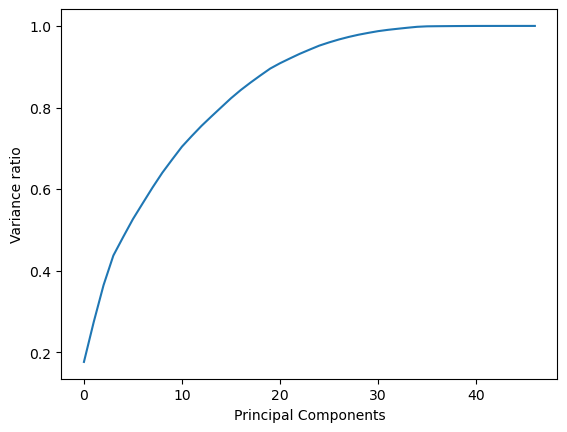

In [127]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal Components')
plt.ylabel('Variance ratio')
plt.show()

In [128]:
n_components = 40
pca = PCA(n_components)
pca_scores_train = pca.fit_transform(X_resampled)

In [129]:
pca_scores_train

array([[-5.91981615e-01,  6.40567865e-01,  2.62480855e-01, ...,
         3.02604835e-03, -1.39365080e-04, -2.14094511e-04],
       [ 4.23261816e-02,  5.27710988e-01,  3.18966436e-01, ...,
         6.80265098e-03,  6.02465481e-04,  2.68973744e-04],
       [ 5.52218097e-01,  2.08074422e-01, -6.00630008e-01, ...,
         7.55746201e-03,  2.87948704e-05, -3.75090622e-04],
       ...,
       [ 4.74783867e-01, -2.48616607e-01,  7.71758680e-01, ...,
         3.95843474e-01, -9.86690176e-03, -2.12937088e-03],
       [-6.82386091e-01, -7.32221674e-01, -1.77921355e-01, ...,
         1.33430935e-04, -6.77373840e-04,  2.42182744e-04],
       [-7.02788218e-01, -6.52907629e-01, -1.96138117e-01, ...,
        -5.78540353e-03,  6.15783785e-04, -1.51543627e-04]])

In [130]:
columns_pca = []
for i in range(n_components):
    columns_pca.append('PCA'+str(i+1))
print(columns_pca)

['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13', 'PCA14', 'PCA15', 'PCA16', 'PCA17', 'PCA18', 'PCA19', 'PCA20', 'PCA21', 'PCA22', 'PCA23', 'PCA24', 'PCA25', 'PCA26', 'PCA27', 'PCA28', 'PCA29', 'PCA30', 'PCA31', 'PCA32', 'PCA33', 'PCA34', 'PCA35', 'PCA36', 'PCA37', 'PCA38', 'PCA39', 'PCA40']


In [131]:
pca_coor = pd.DataFrame(data = pca_scores_train
             , columns = columns_pca, index = X_resampled.index)
pca_coor

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA31,PCA32,PCA33,PCA34,PCA35,PCA36,PCA37,PCA38,PCA39,PCA40
encounter_id,,,,,,,,,,,,,,,,,,,,,
545874,-0.591982,0.640568,0.262481,-0.433367,-0.117458,0.011038,0.248038,0.110140,-0.211744,-0.385468,...,0.014887,-0.027076,-0.007287,-0.030134,0.015578,-0.007387,-0.003186,0.003026,-0.000139,-0.000214
211450,0.042326,0.527711,0.318966,-0.665871,-0.399240,-0.106738,-0.600482,-0.033234,-0.066038,-0.215021,...,-0.015807,-0.032794,-0.000566,-0.001204,0.012931,0.003192,0.000739,0.006803,0.000602,0.000269
392566,0.552218,0.208074,-0.600630,0.110296,-0.325371,-0.328642,-0.122867,-0.378026,0.895652,0.113628,...,0.025995,0.004055,0.009176,0.017387,0.109420,-0.005010,-0.001682,0.007557,0.000029,-0.000375
207567,-0.584403,0.618188,0.266824,-0.400137,-0.305784,-0.026166,-0.019016,-0.388348,-0.191885,-0.116840,...,0.018088,0.162527,-0.006305,0.003549,0.107175,-0.006927,-0.002271,-0.017652,0.001138,0.000213
928602,0.051867,0.515604,0.331515,-0.683087,-0.338337,-0.132807,-0.587621,-0.041747,0.027648,-0.213103,...,-0.062537,-0.022477,-0.006516,-0.011024,-0.032957,0.003090,-0.000100,0.005710,0.001110,-0.000088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303875,0.995845,-0.363665,0.795080,0.132294,-0.013358,-0.116668,0.078229,-0.383996,-0.206638,0.155061,...,-0.039948,-0.085210,0.002408,-0.017308,-0.093660,0.003828,-0.000238,0.006933,-0.000512,-0.001503
397885,-0.062889,-0.309065,0.780615,-0.434390,-0.231200,-0.111778,-0.429857,0.168389,0.073247,0.030622,...,-0.209018,-0.055014,0.010573,0.032119,0.086919,-0.001185,0.001048,-0.008205,0.000409,0.000595
435330,0.474784,-0.248617,0.771759,0.375896,-0.296870,-0.362948,-0.212443,-0.262025,0.870661,-0.166381,...,-0.076157,-0.139106,-0.010507,-0.019806,-0.041617,-0.008430,-0.001009,0.395843,-0.009867,-0.002129


In [132]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [1.76433426e-01 9.80373672e-02 9.01493778e-02 7.25466490e-02
 4.53694652e-02 4.40778801e-02 3.88727341e-02 3.85209527e-02
 3.63316096e-02 3.22550339e-02 3.15471287e-02 2.60264289e-02
 2.50212855e-02 2.28525305e-02 2.23760890e-02 2.22793774e-02
 2.02027154e-02 1.83688646e-02 1.73721315e-02 1.68029586e-02
 1.30740337e-02 1.16479467e-02 1.13376222e-02 1.02026484e-02
 9.92694406e-03 7.90949669e-03 7.16538243e-03 6.22479885e-03
 5.43692213e-03 4.56304084e-03 4.21185385e-03 3.22475922e-03
 2.64410992e-03 2.52723348e-03 2.30443251e-03 1.15836236e-03
 2.91441156e-04 2.13122333e-04 1.84309081e-04 1.22916714e-04]


In [133]:
results_dict = {
        "Proportion": pca.explained_variance_ratio_,
        "Cumulative": np.cumsum(pca.explained_variance_ratio_),
    }
results_dict_df = pd.DataFrame(results_dict, index=pca_coor.columns.values )
results_dict_df


,Proportion,Cumulative
PCA1,0.176433,0.176433
PCA2,0.098037,0.274471
PCA3,0.090149,0.364620
PCA4,0.072547,0.437167
PCA5,0.045369,0.482536
PCA6,0.044078,0.526614
PCA7,0.038873,0.565487
PCA8,0.038521,0.604008
PCA9,0.036332,0.640339
PCA10,0.032255,0.672594


In [134]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [135]:
loadings

array([[ 1.43657457e-05, -1.85921997e-03, -3.70551359e-03, ...,
         8.52408669e-05,  1.59158403e-05,  2.92789436e-06],
       [ 1.24949783e-02, -4.58716120e-03, -5.26799141e-03, ...,
         1.93634044e-04, -4.53449729e-05, -4.02056347e-05],
       [-2.62120960e-02, -5.45715255e-03,  1.04692516e-03, ...,
        -3.32160513e-05,  4.84984854e-06,  3.86304501e-06],
       ...,
       [ 1.56583737e-02, -2.34347503e-01, -4.38572657e-01, ...,
         5.84045819e-06,  1.79698351e-05,  2.02371255e-06],
       [-4.26675333e-01,  4.61461124e-02, -3.01117143e-02, ...,
         8.03373689e-06, -6.48741421e-06, -1.88782793e-05],
       [-3.22826874e-01,  2.41578673e-02, -1.37915393e-02, ...,
         1.01455708e-05,  7.33724049e-06, -3.96537107e-05]])

In [136]:
X_resampled.columns.values

array(['race', 'age', 'payer_code', 'admission_type', 'medical_specialty',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'log_outpatient_visits_in_previous_year',
       'log_emergency_visits_in_previous_year',
       'log_inpatient_visits_in_previous_year', 'visits_in_previous_year',
       'medication_acarbose', 'medication_acetohexamide',
       'medication_chlorpropamide', 'medication_glimepiride',
       'medication_glimepiride-pioglitazone', 'medication_glipizide',
       'medication_glipizide-metformin', 'medication_glyburide',
       'medication_glyburide-metformin', 'medication_insulin',
       'medication_metformin', 'medication_metformin-pioglitazone',
       'medication_metformin-rosiglitazone', 'medication_miglitol',
       'medication_n

In [137]:
loadings_sat_df = pd.DataFrame(data = loadings
             , columns = columns_pca, index = X_resampled.columns.values)

In [138]:
loadings_sat_df

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA31,PCA32,PCA33,PCA34,PCA35,PCA36,PCA37,PCA38,PCA39,PCA40
race,0.000014,-1.859220e-03,-3.705514e-03,-5.759599e-03,2.765122e-03,-1.748176e-03,2.443232e-03,7.269841e-03,-6.126483e-03,-8.067574e-03,...,4.753912e-03,-2.655343e-03,-5.553625e-04,-9.751461e-04,1.992275e-03,1.060032e-04,2.306421e-05,8.524087e-05,1.591584e-05,2.927894e-06
age,0.012495,-4.587161e-03,-5.267991e-03,9.963453e-03,-1.202302e-02,1.511821e-02,1.255980e-02,-1.136202e-02,3.525454e-02,5.484639e-03,...,2.828596e-03,7.405746e-03,1.321834e-04,-8.487755e-04,3.540214e-03,3.475868e-05,-5.470785e-05,1.936340e-04,-4.534497e-05,-4.020563e-05
payer_code,-0.026212,-5.457153e-03,1.046925e-03,-1.702886e-04,-2.487496e-02,-6.468305e-03,-1.932467e-02,-1.278713e-02,-5.691705e-02,-2.053063e-02,...,4.312172e-03,-2.740436e-03,1.227366e-03,-1.000602e-03,4.072004e-04,8.333422e-05,2.313030e-05,-3.321605e-05,4.849849e-06,3.863045e-06
admission_type,-0.002084,1.885569e-02,-1.501413e-03,-2.300916e-03,4.559733e-02,6.169518e-03,4.334064e-02,6.682544e-02,1.980891e-02,4.869030e-03,...,-4.919810e-02,-8.395173e-04,2.452237e-04,8.769118e-04,3.715262e-03,-3.831779e-04,3.117967e-05,-2.565375e-05,1.734106e-06,5.330321e-06
medical_specialty,0.011726,-1.699439e-02,3.877207e-03,1.160289e-02,-7.011508e-02,-3.388725e-02,-1.486089e-01,-2.410982e-01,-1.908715e-03,7.072311e-02,...,-3.585420e-03,1.952242e-03,4.449532e-04,2.211463e-04,-6.758505e-04,1.642848e-04,3.047213e-05,3.373449e-05,3.182631e-05,-5.339085e-06
average_pulse_bpm,0.003800,6.001005e-04,-1.816837e-03,-1.636470e-03,-2.832493e-03,9.764677e-03,7.654671e-03,-1.169973e-03,-1.299099e-02,2.254486e-02,...,9.652117e-05,1.147011e-05,-2.034880e-04,-1.399629e-04,-6.962698e-06,-6.431414e-05,1.254656e-05,9.686837e-06,-1.752964e-06,-1.577269e-05
discharge_disposition,0.014553,-1.128110e-02,9.470464e-04,6.310977e-03,7.069636e-03,-1.120013e-02,3.838570e-03,-2.393264e-02,2.597201e-02,2.170640e-02,...,8.081829e-06,2.137476e-04,-1.144678e-04,8.345616e-04,-4.242567e-04,-2.007575e-05,-3.909393e-05,-6.346183e-05,-2.697111e-05,-3.796665e-05
admission_source,0.002825,1.512135e-02,-2.275952e-03,-2.276920e-04,2.632966e-02,8.421720e-04,1.778058e-02,2.981910e-02,1.911315e-02,8.034538e-03,...,8.873070e-02,1.004304e-03,-2.720375e-04,-1.919994e-03,-1.123543e-02,4.554521e-04,-7.350721e-05,2.269579e-04,2.695155e-05,-1.554059e-05
length_of_stay_in_hospital,-0.027143,-9.371306e-03,-1.714550e-03,-7.262050e-03,2.611501e-02,-1.063700e-03,4.414200e-02,-2.302501e-02,2.534987e-02,1.280813e-01,...,-8.566685e-03,3.772314e-03,8.026057e-05,-4.444271e-03,-1.035011e-02,2.353099e-04,-3.258957e-05,-3.866777e-06,9.128207e-06,-4.134094e-06
number_lab_tests,-0.013410,2.236749e-03,-1.486640e-03,-1.421159e-02,2.697938e-02,-2.153801e-03,5.605372e-03,-2.134942e-02,3.953961e-03,3.730459e-02,...,2.097311e-02,2.124833e-03,3.270399e-05,-2.355857e-03,-9.536901e-03,2.331892e-04,-2.718196e-05,-2.309925e-05,-6.814505e-06,-1.885319e-06


## Feature Selection <a class="anchor" id="fselection"></a>

## Filter methods <a class="anchor" id="filter"></a>

### Univariate variables <a class="anchor" id="univariate"></a>

In [139]:
feat_no_var = X_resampled.var().loc[X_resampled.var() == 0].index.values.tolist()
feat_no_var

['medication_metformin-pioglitazone', 'medication_metformin-rosiglitazone']

### Chi-squared for categorical variables <a class="anchor" id="chi2"></a>

In [140]:
def check_independence(X,y,var):
    df_observed = pd.crosstab(y,X)
    chi2, p, dof, expected = chi2_contingency(df_observed.values)
    if p<0.05:
        return 1
    else:
        return 0

In [143]:
selected_vars = []
# for each feature test importance using chi squared
for var in X_resampled[categorical_features]:
  res = check_independence(X_resampled[var],y_resampled, var)
  if res == 1:
    # if feature is important append to selected features
    selected_vars.append(var)
selected_vars


['race',
 'age',
 'payer_code',
 'admission_type',
 'medical_specialty',
 'discharge_disposition',
 'admission_source',
 'primary_diagnosis',
 'secondary_diagnosis',
 'additional_diagnosis',
 'medication_acarbose',
 'medication_glimepiride',
 'medication_insulin',
 'medication_metformin',
 'medication_repaglinide',
 'medication_rosiglitazone',
 'weight_bin',
 'test_result',
 'regular_patient',
 'gender_bin',
 'change_in_meds_during_hospitalization_bin',
 'prescribed_diabetes_meds_bin']

### Mutual information for numerical variables <a class="anchor" id="mutual_info"></a>

In [144]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=8)
bestfeatures.fit(X_resampled[numerical_features],y_resampled)

cols = bestfeatures.get_support(indices=True)
selected_columns = X_resampled[numerical_features].iloc[:,cols].columns.tolist()

print(selected_columns)

['log_outpatient_visits_in_previous_year', 'log_emergency_visits_in_previous_year', 'log_inpatient_visits_in_previous_year', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses', 'visits_in_previous_year']


### Spearman Correlation <a class="anchor" id="spearman"></a>

In [163]:
data_with_target = X_resampled[numerical_features].join(y_resampled)
cor_spearman = data_with_target.corr(method="spearman")
cor_spearman.head()

,log_outpatient_visits_in_previous_year,log_emergency_visits_in_previous_year,log_inpatient_visits_in_previous_year,average_pulse_bpm,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,number_diagnoses,visits_in_previous_year,readmitted_multiclass
log_outpatient_visits_in_previous_year,1.000000,0.190251,0.162847,0.005302,-0.013198,-0.022118,-0.028546,0.069584,0.108340,0.563456,0.092810
log_emergency_visits_in_previous_year,0.190251,1.000000,0.243618,0.003916,-0.018698,-0.002028,-0.037138,0.034268,0.093619,0.474360,0.091491
log_inpatient_visits_in_previous_year,0.162847,0.243618,1.000000,0.002159,0.084430,0.035116,-0.064314,0.098907,0.125563,0.813835,0.163647
average_pulse_bpm,0.005302,0.003916,0.002159,1.000000,0.004942,-0.012724,-0.000571,0.002424,-0.006810,0.005327,-0.006027
length_of_stay_in_hospital,-0.013198,-0.018698,0.084430,0.004942,1.000000,0.330064,0.209315,0.468963,0.230135,0.045613,0.035398


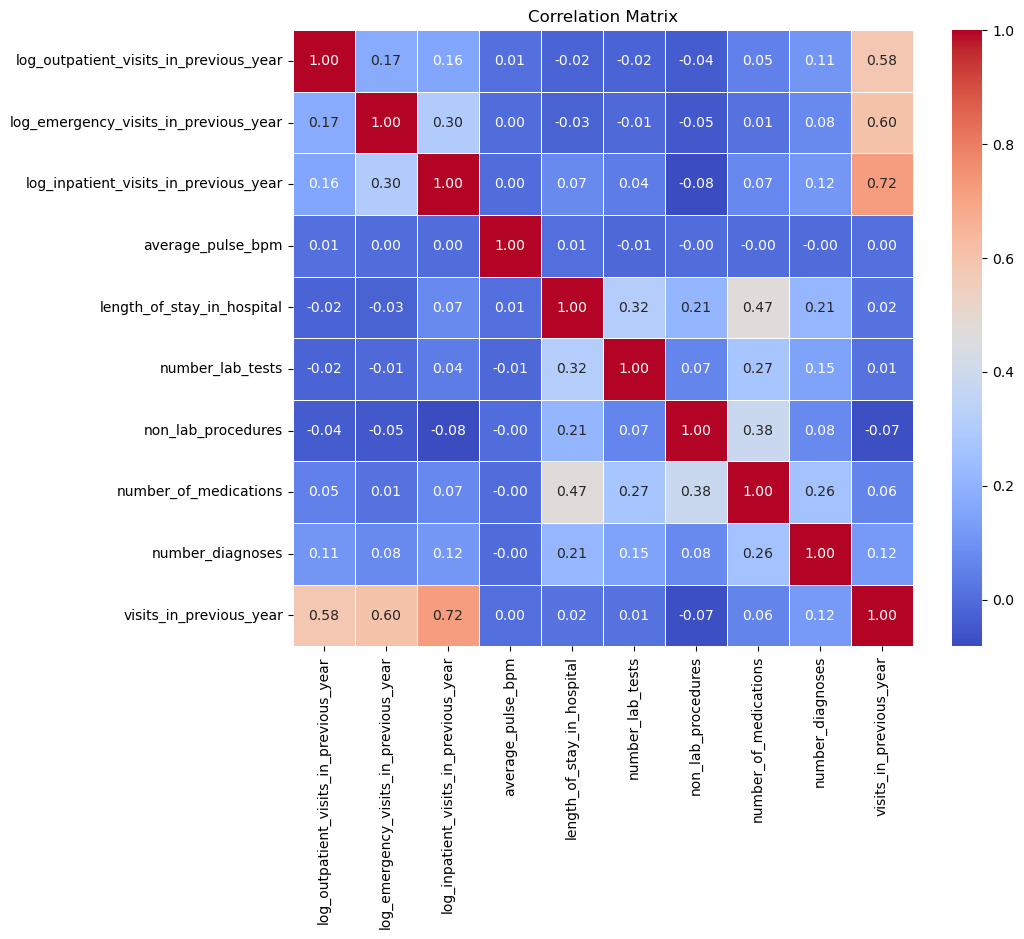

In [164]:
correlation_matrix = X_resampled[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [144]:
high_corr_variables = cor_spearman["readmitted_multiclass"][abs(cor_spearman["readmitted_multiclass"]) > 0.75].index.tolist()

# Print or use the high correlation variables
print(high_corr_variables)

['readmitted_multiclass']


# Wrapper methods - RFE <a class="anchor" id="rfe"></a>

In [145]:
'''
nof_list=np.arange(1,48) # desde 1 até 48 deu 8 features com .score de 0.681530
high_score=0
# Variable to store the optimum features
nof=0
score_list =[]
for i in range(len(nof_list)):
    model = RandomForestClassifier(random_state=42)
    rfe = RFE(model, n_features_to_select=nof_list[i]) # 8 nof_list[i]
    X_train_rfe = rfe.fit_transform(X_resampled, y_resampled)
    X_val_rfe= rfe.transform(X_val)
    model.fit(X_train_rfe,y_resampled)

    score = model.score(X_val_rfe,y_val)
    score_list.append(score)

    if(score>high_score):
        high_score = score
        nof = nof_list[i]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

rfe = RFE(RandomForestClassifier(random_state=42), n_features_to_select=8) # not
X_train_rfe = rfe.fit_transform(X_resampled, y_resampled)
model.fit(X_train_rfe,y_resampled)

rfe_selected_features = pd.Series(rfe.support_, index=X_resampled.columns)
print(rfe_selected_features)
'''

'\nnof_list=np.arange(1,48) # desde 1 até 48 deu 8 features com .score de 0.681530\nhigh_score=0\n# Variable to store the optimum features\nnof=0\nscore_list =[]\nfor i in range(len(nof_list)):\n    model = RandomForestClassifier(random_state=42)\n    rfe = RFE(model, n_features_to_select=nof_list[i]) # 8 nof_list[i]\n    X_train_rfe = rfe.fit_transform(X_resampled, y_resampled)\n    X_val_rfe= rfe.transform(X_val)\n    model.fit(X_train_rfe,y_resampled)\n\n    score = model.score(X_val_rfe,y_val)\n    score_list.append(score)\n\n    if(score>high_score):\n        high_score = score\n        nof = nof_list[i]\n\nprint("Optimum number of features: %d" %nof)\nprint("Score with %d features: %f" % (nof, high_score))\n\nrfe = RFE(RandomForestClassifier(random_state=42), n_features_to_select=8) # not\nX_train_rfe = rfe.fit_transform(X_resampled, y_resampled)\nmodel.fit(X_train_rfe,y_resampled)\n\nrfe_selected_features = pd.Series(rfe.support_, index=X_resampled.columns)\nprint(rfe_selected_f

In [146]:
X_resampled.columns

Index(['race', 'age', 'payer_code', 'admission_type', 'medical_specialty',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'number_diagnoses',
       'log_outpatient_visits_in_previous_year',
       'log_emergency_visits_in_previous_year',
       'log_inpatient_visits_in_previous_year', 'visits_in_previous_year',
       'medication_acarbose', 'medication_acetohexamide',
       'medication_chlorpropamide', 'medication_glimepiride',
       'medication_glimepiride-pioglitazone', 'medication_glipizide',
       'medication_glipizide-metformin', 'medication_glyburide',
       'medication_glyburide-metformin', 'medication_insulin',
       'medication_metformin', 'medication_metformin-pioglitazone',
       'medication_metformin-rosiglitazone', 'medication_miglitol',
       'medication_n

In [147]:
rfe_selected_features = ['average_pulse_bpm','length_of_stay_in_hospital','number_lab_tests','number_of_medications',
                        'primary_diagnosis', 'secondary_diagnosis','additional_diagnosis','regular_patient']

In [148]:
#rfe_selected_features = rfe_selected_features[rfe_selected_features==True].index.tolist()

# Embedded methods - Lasso <a class="anchor" id="lasso"></a>

In [149]:
sns.set(style="whitegrid")
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.savefig(name+'_plot_importance.png', dpi=200)
    plt.show()

In [150]:
# Baseline dataset (X_train + Y_train)
reg = LassoCV(random_state=42)
reg.fit(X_resampled, y_resampled)
coef = pd.Series(reg.coef_, index = X_resampled.columns)
print(coef.sort_values())

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
# The variables with the value 0 are supposedly dropped.
lasso_selected_features = coef[coef!=0].index.tolist()

discharge_disposition                       -0.248851
admission_source                            -0.201131
payer_code                                  -0.161729
visits_in_previous_year                     -0.158220
number_of_medications                       -0.070927
non_lab_procedures                          -0.062296
medication_metformin                        -0.037903
primary_diagnosis                           -0.031118
secondary_diagnosis                         -0.022028
medication_insulin                          -0.015289
average_pulse_bpm                           -0.013837
race                                        -0.012436
change_in_meds_during_hospitalization_bin   -0.005259
medication_glyburide                        -0.000117
medication_glimepiride-pioglitazone          0.000000
medication_glipizide-metformin               0.000000
medication_metformin-rosiglitazone           0.000000
medication_acetohexamide                     0.000000
medication_miglitol         

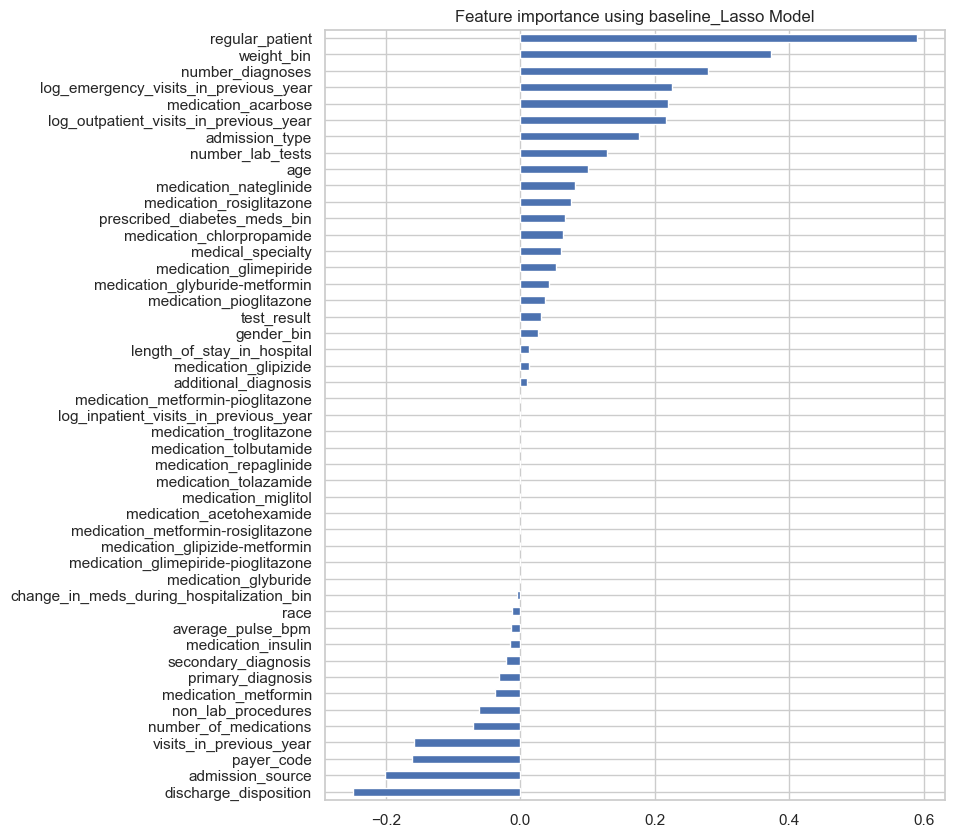

In [151]:
plot_importance(coef,'baseline_Lasso')

# Embedded methods - DecisionTree <a class="anchor" id="dt"></a>

<Axes: xlabel='Value', ylabel='Col'>

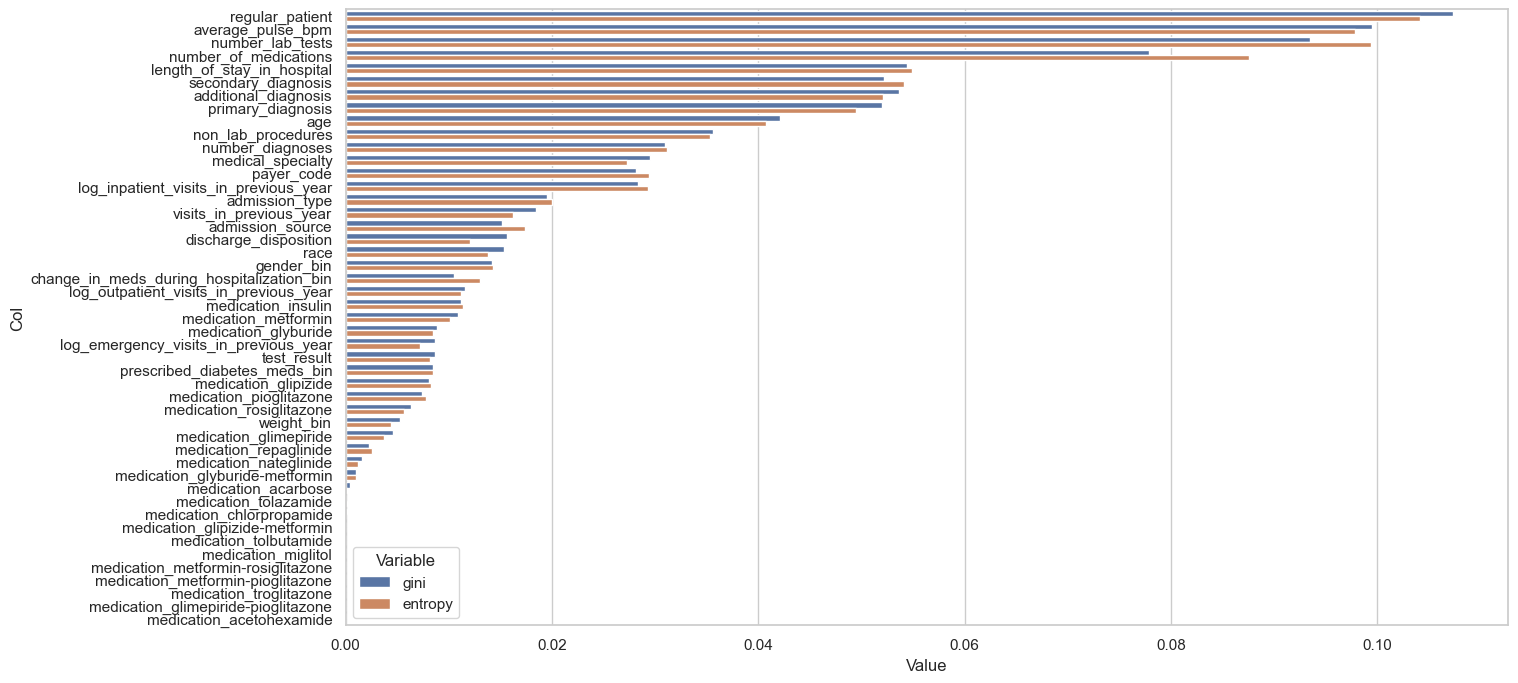

In [152]:
sns.set(style="whitegrid")

gini_importance = DecisionTreeClassifier().fit(X_resampled, y_resampled).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_resampled, y_resampled).feature_importances_

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns = ['gini','entropy'])
zippy['col'] = X_resampled.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,8))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [153]:
selected_features_gini = []
selected_features_entropy = []
print("For GINI INDEX")
association_dict = dict(zip(gini_importance, X_train.columns))
for column, value in association_dict.items():
    if column > (100/47)/100:
        print(f"{column}: {value}")
        selected_features_gini.append(value)

print("-----------------------\n")
print("For ENTROPY IMPORTANCE")
association_dict_e = dict(zip(entropy_importance, X_train.columns))
for column, value in association_dict_e.items():
    if column > (100/47)/100:
        print(f"{column}: {value}")
        selected_features_entropy.append(value)
        
print("-----------------------\n")
print(set(selected_features_gini).intersection(set(selected_features_entropy)))
print(len(set(selected_features_gini).intersection(set(selected_features_entropy))))

For GINI INDEX
0.042128242102484066: age
0.028166865430379866: payer_code
0.029483266248005645: medical_specialty
0.09949094863691432: average_pulse_bpm
0.05443268000384028: length_of_stay_in_hospital
0.09350785113349513: number_lab_tests
0.03564549463857591: non_lab_procedures
0.07787357861772179: number_of_medications
0.05195613957126491: primary_diagnosis
0.052216498927018996: secondary_diagnosis
0.05366565936497315: additional_diagnosis
0.030924694258155874: number_diagnoses
0.028387528921380172: log_inpatient_visits_in_previous_year
0.10730991024097448: regular_patient
-----------------------

For ENTROPY IMPORTANCE
0.04075779043496524: age
0.029398650546542827: payer_code
0.0272950899293776: medical_specialty
0.09786902561316195: average_pulse_bpm
0.05494955222068735: length_of_stay_in_hospital
0.09943300735900659: number_lab_tests
0.035336834098646644: non_lab_procedures
0.08754646425103722: number_of_medications
0.04949086036106022: primary_diagnosis
0.054104651955336786: secon

In [154]:
dt_selected_features = set(selected_features_gini).intersection(set(selected_features_entropy))
dt_selected_features

{'additional_diagnosis',
 'age',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'log_inpatient_visits_in_previous_year',
 'medical_specialty',
 'non_lab_procedures',
 'number_diagnoses',
 'number_lab_tests',
 'number_of_medications',
 'payer_code',
 'primary_diagnosis',
 'regular_patient',
 'secondary_diagnosis'}

### Best Feature Selection ( intersection between all methods )

In [155]:
final_features = []

for i in lasso_selected_features:
    #print(i)
    final_features.append(i)
for i in rfe_selected_features:
    #print(i)
    final_features.append(i)
for i in dt_selected_features:
    #print(i)
    final_features.append(i)

In [156]:
feature_counts = Counter(final_features)

final_selected_features = [feature for feature, count in feature_counts.items() if count >= 2]

print(final_selected_features)
len(final_selected_features)

['age', 'payer_code', 'medical_specialty', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses', 'regular_patient']


13

In [157]:
metric_final_selected_features = ["age", 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests','number_of_medications','number_diagnoses',
'non_lab_procedures']
categorical_final_selected_features = [feature for feature in final_selected_features if feature not in metric_final_selected_features]

print(categorical_final_selected_features)

['payer_code', 'medical_specialty', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'regular_patient']


In [158]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

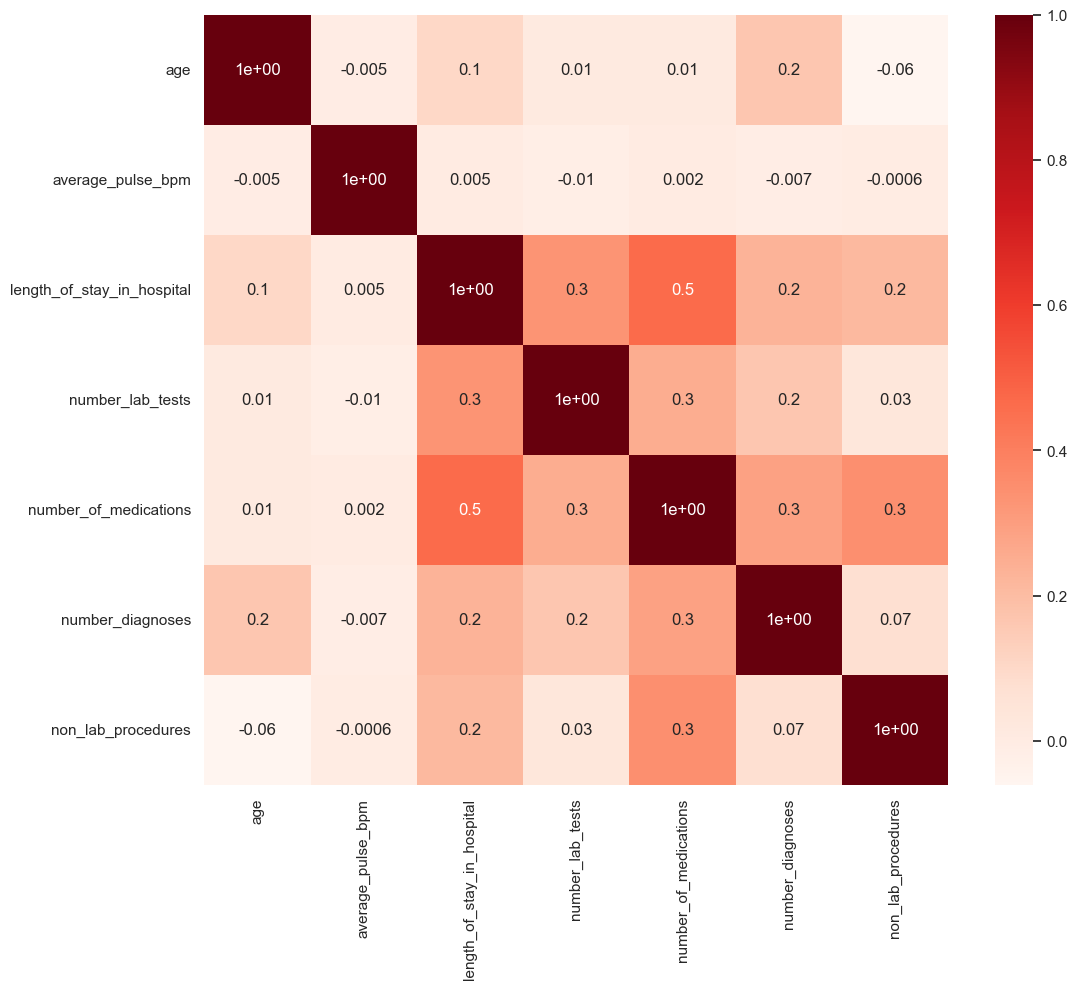

In [159]:
cor_heatmap(X_resampled[metric_final_selected_features].corr(method="spearman"))

In [160]:
X_resampled = X_resampled[final_selected_features]
test = test[final_selected_features]

# Modeling Selection and Evaluation <a class="anchor" id="model_selection"></a>

In [161]:
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

models = ['LogisticReg', 'KNN', 'DecisionTree', 'SVM', 'NaiveBayes', 'BaggingClassifier', 'RandomForest', 'AdaBoost', 'GradBoost', 'MLP']

models_train_score = {}
models_val_score = {}

for model in models:
    models_train_score[model] = []
    models_val_score[model] = []

for train_index, val_index in rkf.split(X_resampled, y_resampled):
    X_train, X_val = X_resampled.iloc[train_index], X_resampled.iloc[val_index]
    y_train, y_val = y_resampled.iloc[train_index], y_resampled.iloc[val_index]

    # Logistic Regression
    logistic_clf = LogisticRegression(C=10, random_state=42).fit(X_train, y_train)
    y_pred = logistic_clf.predict(X_train)
    models_train_score['LogisticReg'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = logistic_clf.predict(X_val)
    models_val_score['LogisticReg'].append(f1_score(y_val, y_pred, average='weighted'))

    # KNN
    KNN_clf = KNeighborsClassifier().fit(X_train, y_train)
    y_pred = KNN_clf.predict(X_train)
    models_train_score['KNN'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = KNN_clf.predict(X_val)
    models_val_score['KNN'].append(f1_score(y_val, y_pred, average='weighted'))

    # Decision Tree
    tree_clf = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
    y_pred = tree_clf.predict(X_train)
    models_train_score['DecisionTree'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = tree_clf.predict(X_val)
    models_val_score['DecisionTree'].append(f1_score(y_val, y_pred, average='weighted'))

    # SVM
    svm_clf = SVC(random_state=42).fit(X_train, y_train)
    y_pred = svm_clf.predict(X_train)
    models_train_score['SVM'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = svm_clf.predict(X_val)
    models_val_score['SVM'].append(f1_score(y_val, y_pred, average='weighted'))

    # GaussianNB
    nb_clf = GaussianNB().fit(X_train, y_train)
    y_pred = nb_clf.predict(X_train)
    models_train_score['NaiveBayes'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = nb_clf.predict(X_val)
    models_val_score['NaiveBayes'].append(f1_score(y_val, y_pred, average='weighted'))

    # BaggingClassifier
    bagging_clf = BaggingClassifier(random_state=42).fit(X_train, y_train)
    y_pred = bagging_clf.predict(X_train)
    models_train_score['BaggingClassifier'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = bagging_clf.predict(X_val)
    models_val_score['BaggingClassifier'].append(f1_score(y_val, y_pred, average='weighted'))

    # Random Forest
    forest_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
    y_pred = forest_clf.predict(X_train)
    models_train_score['RandomForest'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = forest_clf.predict(X_val)
    models_val_score['RandomForest'].append(f1_score(y_val, y_pred, average='weighted'))

    # Adaptive Boosting with Decision Tree
    adaboost_clf = AdaBoostClassifier(random_state=42).fit(X_train, y_train)
    y_pred = adaboost_clf.predict(X_train)
    models_train_score['AdaBoost'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = adaboost_clf.predict(X_val)
    models_val_score['AdaBoost'].append(f1_score(y_val, y_pred, average='weighted'))

    # Gradient Boosting
    grad_clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
    y_pred = grad_clf.predict(X_train)
    models_train_score['GradBoost'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = grad_clf.predict(X_val)
    models_val_score['GradBoost'].append(f1_score(y_val, y_pred, average='weighted'))

    # MLP
    mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100, 100), random_state=42).fit(X_train, y_train)
    y_pred = mlp_clf.predict(X_train)
    models_train_score['MLP'].append(f1_score(y_train, y_pred, average='weighted'))

    y_pred = mlp_clf.predict(X_val)
    models_val_score['MLP'].append(f1_score(y_val, y_pred, average='weighted'))

# Print or analyze the results as needed
print("Train Scores:")
for model, scores in models_train_score.items():
    print(f"{model}: {sum(scores) / len(scores)}")

print("\nValidation Scores:")
for model, scores in models_val_score.items():
    print(f"{model}: {sum(scores) / len(scores)}")


Train Scores:
LogisticReg: 0.43535300158641216
KNN: 0.6137889867677696
DecisionTree: 1.0
SVM: 0.4543238658055584
NaiveBayes: 0.4632100101567597
BaggingClassifier: 0.9816954294506519
RandomForest: 1.0
AdaBoost: 0.48458640402048336
GradBoost: 0.5118171663860228
MLP: 0.7281492566580721

Validation Scores:
LogisticReg: 0.43210699903724537
KNN: 0.44116100671348824
DecisionTree: 0.41519766502947775
SVM: 0.4367273650512472
NaiveBayes: 0.4579255337488136
BaggingClassifier: 0.4624469452092447
RandomForest: 0.47790657530692193
AdaBoost: 0.4769903917546703
GradBoost: 0.47968280438335614
MLP: 0.44446293753648247


In [162]:
def show_models_results(train_scores, val_scores):
  df = pd.DataFrame(columns = ['Train', 'Val'], index = train_scores.keys())

  for model, scores in train_scores.items():
    df.loc[model, 'Train'] = str(round(np.mean(train_scores[model]),3)) + '+/-' + str(round(np.std(train_scores[model]),2))
    df.loc[model, 'Val'] = str(round(np.mean(val_scores[model]),3)) + '+/-' + str(round(np.std(val_scores[model]),2))

  return df

In [163]:
df = show_models_results(models_train_score, models_val_score)
df

,Train,Val
LogisticReg,0.435+/-0.01,0.432+/-0.01
KNN,0.614+/-0.0,0.441+/-0.01
DecisionTree,1.0+/-0.0,0.415+/-0.01
SVM,0.454+/-0.01,0.437+/-0.01
NaiveBayes,0.463+/-0.0,0.458+/-0.01
BaggingClassifier,0.982+/-0.0,0.462+/-0.01
RandomForest,1.0+/-0.0,0.478+/-0.01
AdaBoost,0.485+/-0.0,0.477+/-0.01
GradBoost,0.512+/-0.0,0.48+/-0.01
MLP,0.728+/-0.01,0.444+/-0.01


# Models Fine Tuning <a class="anchor" id="finetuning"></a>

### Logistic Regression <a class="anchor" id="lr"></a>

In [164]:
'''
# Assuming X_train and y_train are your training data
# Make sure to replace them with your actual training data

LR = LogisticRegression()
LR_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['none', 'l2'],
    'solver': ['lbfgs', 'saga'],
}

# For multiclass classification, set multi_class parameter to 'multinomial'
LR_param_grid['multi_class'] = ['ovr', 'multinomial']

LR_search = GridSearchCV(LR, param_grid=LR_param_grid, cv=10, scoring='f1_macro')
# 'f1_macro' is used for multiclass classification, it calculates F1 score for each class and takes the unweighted average

# fitting the model for grid search
LR_search.fit(X_train, y_train)

# Output the best parameters
print("Best Parameters:", LR_search.best_params_)
'''

'\n# Assuming X_train and y_train are your training data\n# Make sure to replace them with your actual training data\n\nLR = LogisticRegression()\nLR_param_grid = {\n    \'C\': [0.001, 0.01, 0.1, 1, 10, 100, 1000],\n    \'penalty\': [\'none\', \'l2\'],\n    \'solver\': [\'lbfgs\', \'saga\'],\n}\n\n# For multiclass classification, set multi_class parameter to \'multinomial\'\nLR_param_grid[\'multi_class\'] = [\'ovr\', \'multinomial\']\n\nLR_search = GridSearchCV(LR, param_grid=LR_param_grid, cv=10, scoring=\'f1_macro\')\n# \'f1_macro\' is used for multiclass classification, it calculates F1 score for each class and takes the unweighted average\n\n# fitting the model for grid search\nLR_search.fit(X_train, y_train)\n\n# Output the best parameters\nprint("Best Parameters:", LR_search.best_params_)\n'

In [165]:
#best_param=LR_search.best_params_

In [166]:
# Create the model with specified hyperparameters
log_reg2 = LogisticRegression(C=1000, multi_class='multinomial', penalty='l2', solver='lbfgs', random_state=42)

# Create a splitter object
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

scoring_metrics = ["accuracy", "recall_weighted", "precision_weighted", "f1_weighted"]

# Perform cross-validation
cv_score = cross_validate(log_reg2, X_resampled, y_resampled, cv=kfold, scoring=scoring_metrics)

# Output the mean scores for each metric
for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")


accuracy: 0.5067295597484276
recall_weighted: 0.5067295597484276
precision_weighted: 0.4793545766443829
f1_weighted: 0.4319299114680872


### GradientBoostingClassifier <a class="anchor" id="gb"></a>

In [167]:
'''
gradient_boost = GradientBoostingClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
}

random_search = RandomizedSearchCV(gradient_boost, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1_macro', random_state=42, verbose=2)
random_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

best_param = random_search.best_params_
'''

'\ngradient_boost = GradientBoostingClassifier(random_state=42)\n\nparam_dist = {\n    \'n_estimators\': [50, 100, 200],\n    \'learning_rate\': [0.01, 0.1, 0.5],\n    \'max_depth\': [3, 4, 5],\n    \'subsample\': [0.8, 1.0],\n}\n\nrandom_search = RandomizedSearchCV(gradient_boost, param_distributions=param_dist, n_iter=10, cv=5, scoring=\'f1_macro\', random_state=42, verbose=2)\nrandom_search.fit(X_resampled, y_resampled)\n\n# Print the best hyperparameters\nprint("Best Hyperparameters:", random_search.best_params_)\n\nbest_param = random_search.best_params_\n'

In [168]:
gbc = GradientBoostingClassifier(subsample=0.8, n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

# create a splitter object
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

scoring_metrics = ["accuracy", "recall_weighted", "precision_weighted", "f1_weighted"]
cv_score = cross_validate(gbc,
                            X_resampled, y_resampled,
                            cv=kfold,
                            scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.509622641509434
recall_weighted: 0.509622641509434
precision_weighted: 0.4935265553905392
f1_weighted: 0.4872519747649447


### RandomForest <a class="anchor" id="rf"></a>

In [169]:
'''

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform grid search using cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

best_param = grid_search.best_params_
'''

'\n\n# Define the parameter grid\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],\n    \'max_depth\': [None, 10, 20],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4]\n}\n\n# Create a Random Forest classifier\nrf_classifier = RandomForestClassifier(random_state=42)\n\n# Perform grid search using cross-validation\ngrid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring=\'f1_macro\', n_jobs=-1)\ngrid_search.fit(X_resampled, y_resampled)\n\n# Print the best hyperparameters\nprint("Best Hyperparameters:", grid_search.best_params_)\n\nbest_param = grid_search.best_params_\n'

In [170]:
rf_model = RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)

kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


scoring_metrics = ["accuracy", "recall_weighted", "precision_weighted", "f1_weighted"]
cv_score = cross_validate(rf_model,
                            X_resampled, y_resampled,
                            cv=kfold,
                            scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.5038993710691824
recall_weighted: 0.5038993710691824
precision_weighted: 0.48472167808277017
f1_weighted: 0.47773164510278576


### SVC <a class="anchor" id="svc"></a>

In [171]:
'''
# Define the parameter grid
param_dist = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create an SVC classifier
svc_classifier = SVC()

# Perform grid search using cross-validation
random_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_search.fit(X_resampled, y_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

best_param = random_search.best_params_
'''

'\n# Define the parameter grid\nparam_dist = {\n    \'C\': uniform(0.1, 10),\n    \'kernel\': [\'linear\', \'rbf\', \'poly\'],\n    \'gamma\': [\'scale\', \'auto\', 0.1, 1]\n}\n\n# Create an SVC classifier\nsvc_classifier = SVC()\n\n# Perform grid search using cross-validation\nrandom_search = RandomizedSearchCV(svc_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring=\'f1\', n_jobs=-1, random_state=42)\nrandom_search.fit(X_resampled, y_resampled)\n\n# Print the best hyperparameters\nprint("Best Hyperparameters:", random_search.best_params_)\n\nbest_param = random_search.best_params_\n'

In [172]:
svc_classifier = SVC(C=3.845401188473625, gamma='scale', kernel='linear', random_state=42)

kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


scoring_metrics = ["accuracy", "recall_weighted", "precision_weighted", "f1_weighted"]
cv_score = cross_validate(svc_classifier,
                            X_resampled, y_resampled,
                            cv=kfold,
                            scoring=scoring_metrics)

for metric in scoring_metrics:
    print(f"{metric}: {cv_score[f'test_{metric}'].mean()}")

accuracy: 0.509643605870021
recall_weighted: 0.509643605870021
precision_weighted: 0.3397327691894104
f1_weighted: 0.40764407080619114
